# Using the Median and Mean of $n$ buses in a period of 30 minutes

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import heapq 
import pickle
%matplotlib inline
    
import plotnine as p9
import matplotlib.pyplot as plt
import dateutil
import datetime 

from dateutil.rrule import DAILY, rrule, MO, TU, WE, TH, FR

from sklearn.linear_model import LinearRegression, Lasso, BayesianRidge
from sklearn import tree
import math

import warnings
warnings.filterwarnings('ignore')
    

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


import sys
sys.path.append("../")

with open('../data/linhas.pkl', 'rb') as inputfile:  
    linhas = pickle.load(inputfile)

with open('../data/stops_distances_fixed10.pkl', 'rb') as input_file:
    distancias_pontos = pickle.load(input_file)
    
with open('../data/linesedges.pkl', 'rb') as input_file:
    linesedge = pickle.load(input_file)
    
with open('../data/edgeslines.pkl', 'rb') as input_file:
    edgeslines = pickle.load(input_file)


EOFError: Ran out of input

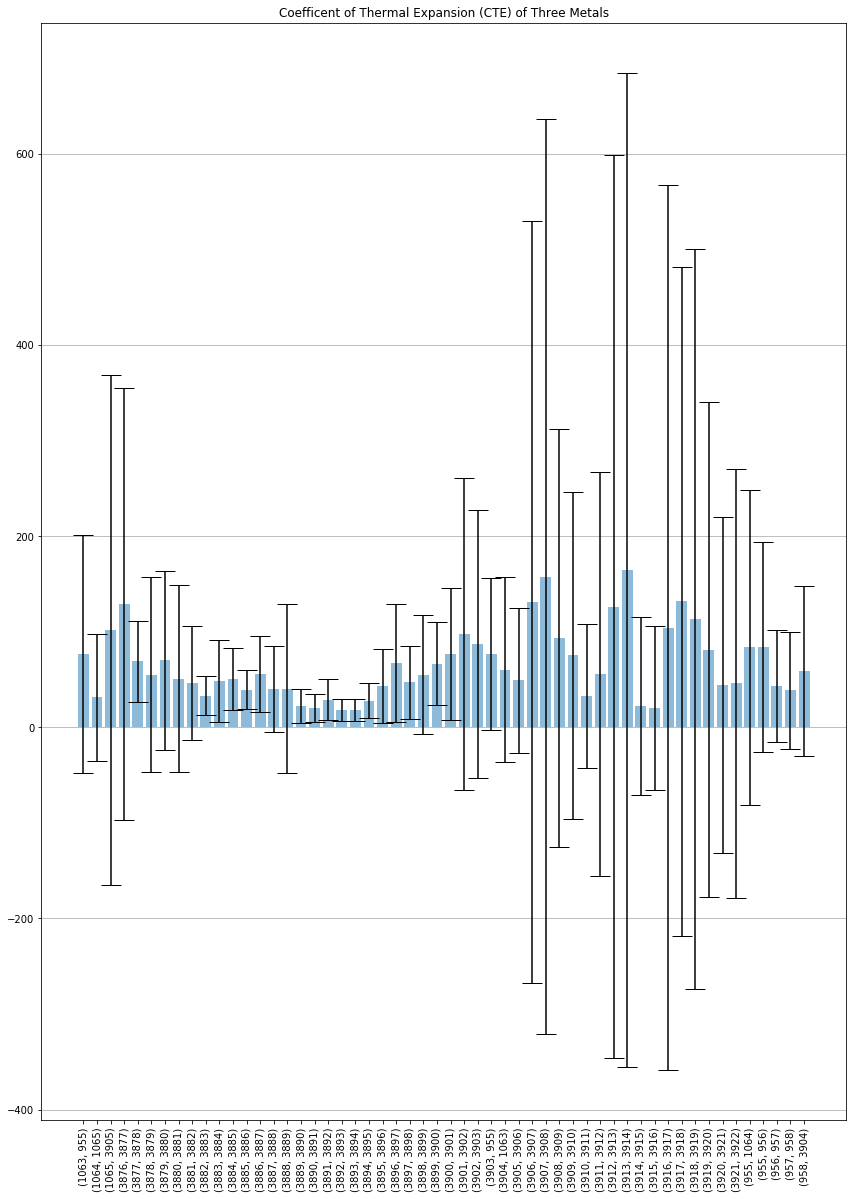

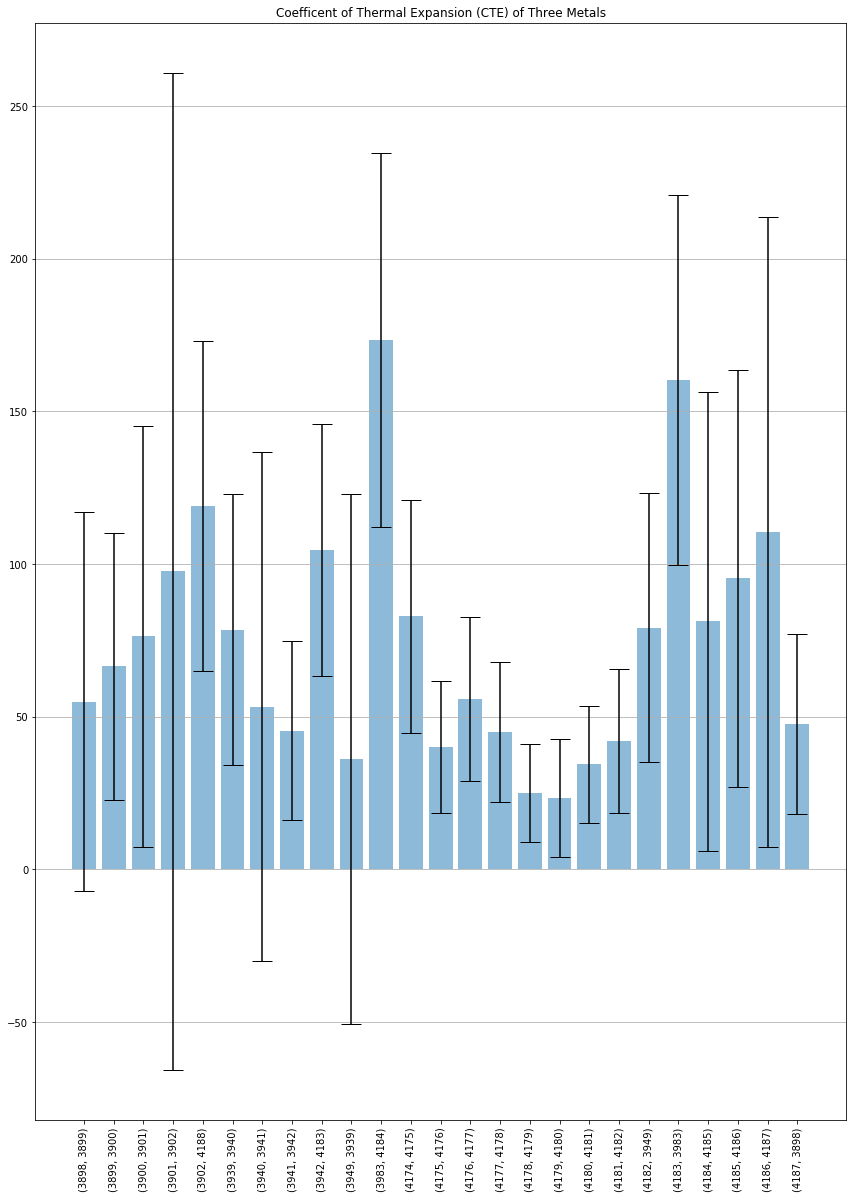

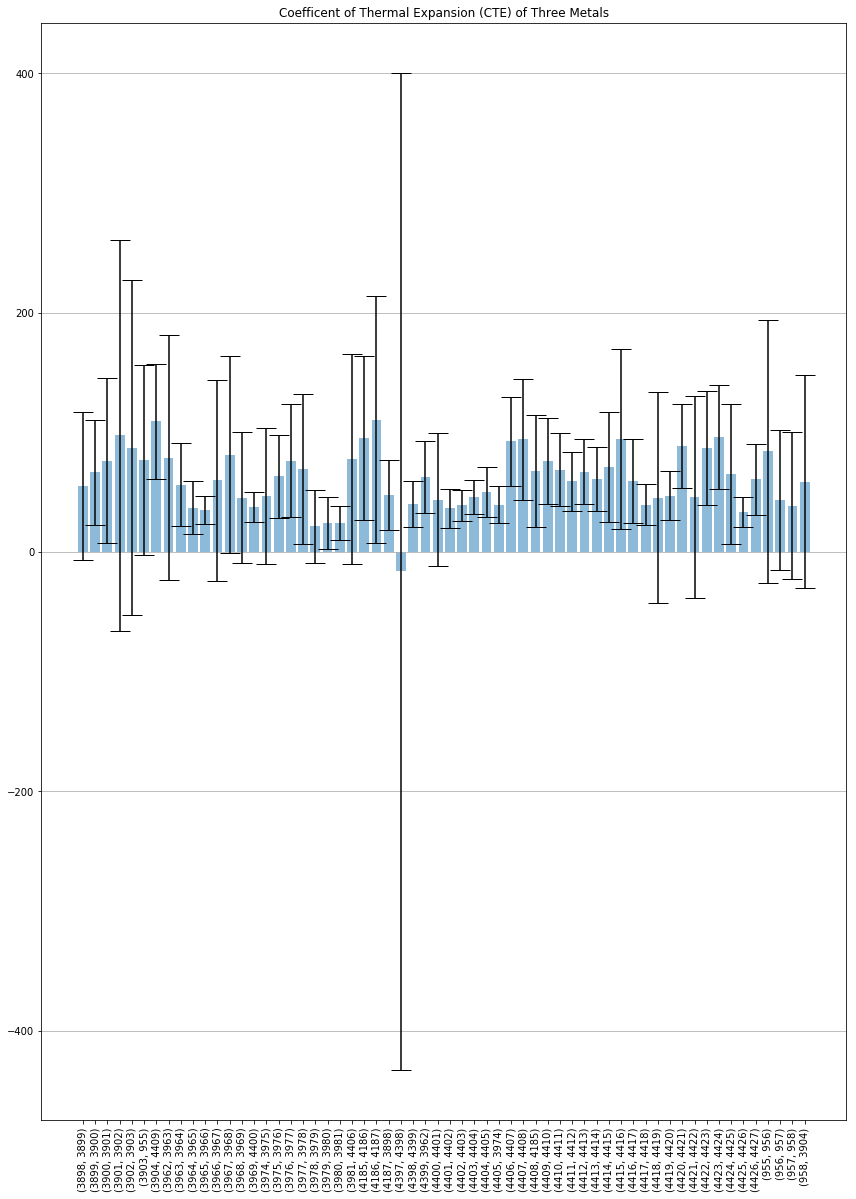

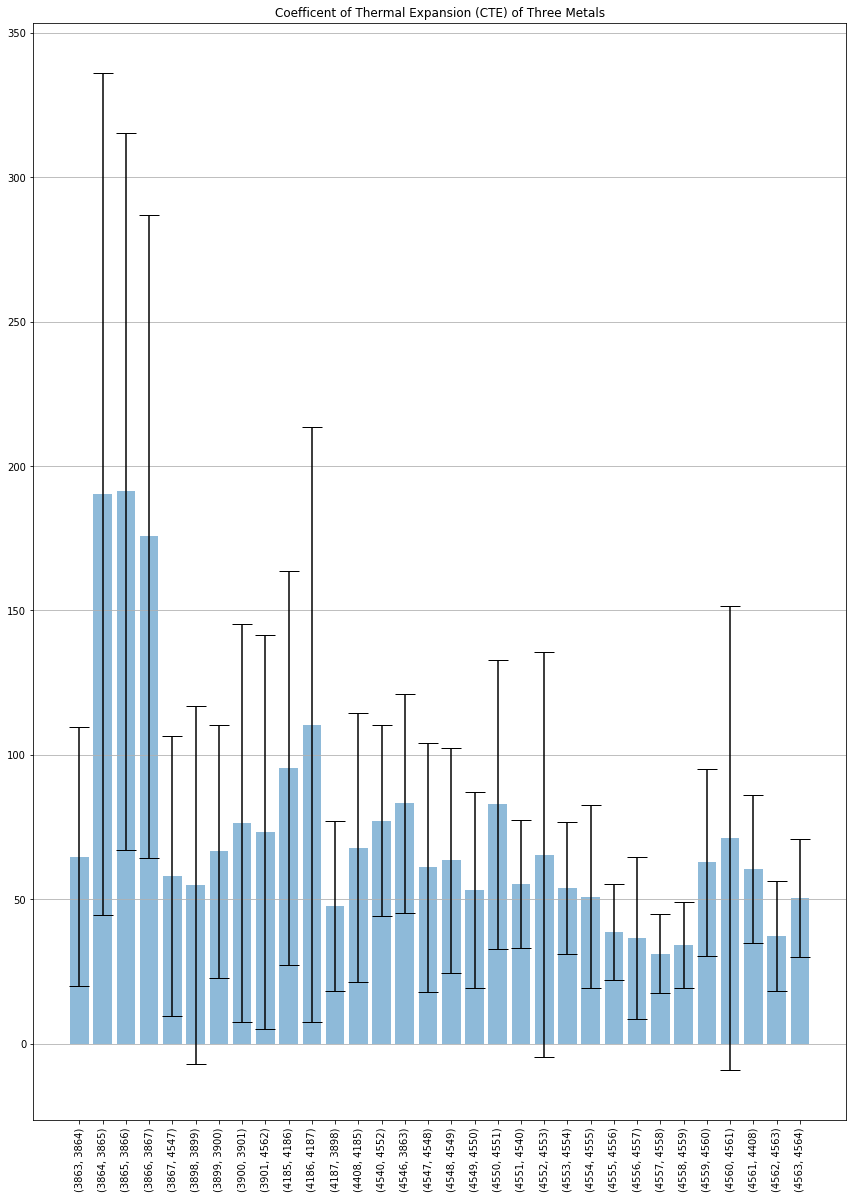

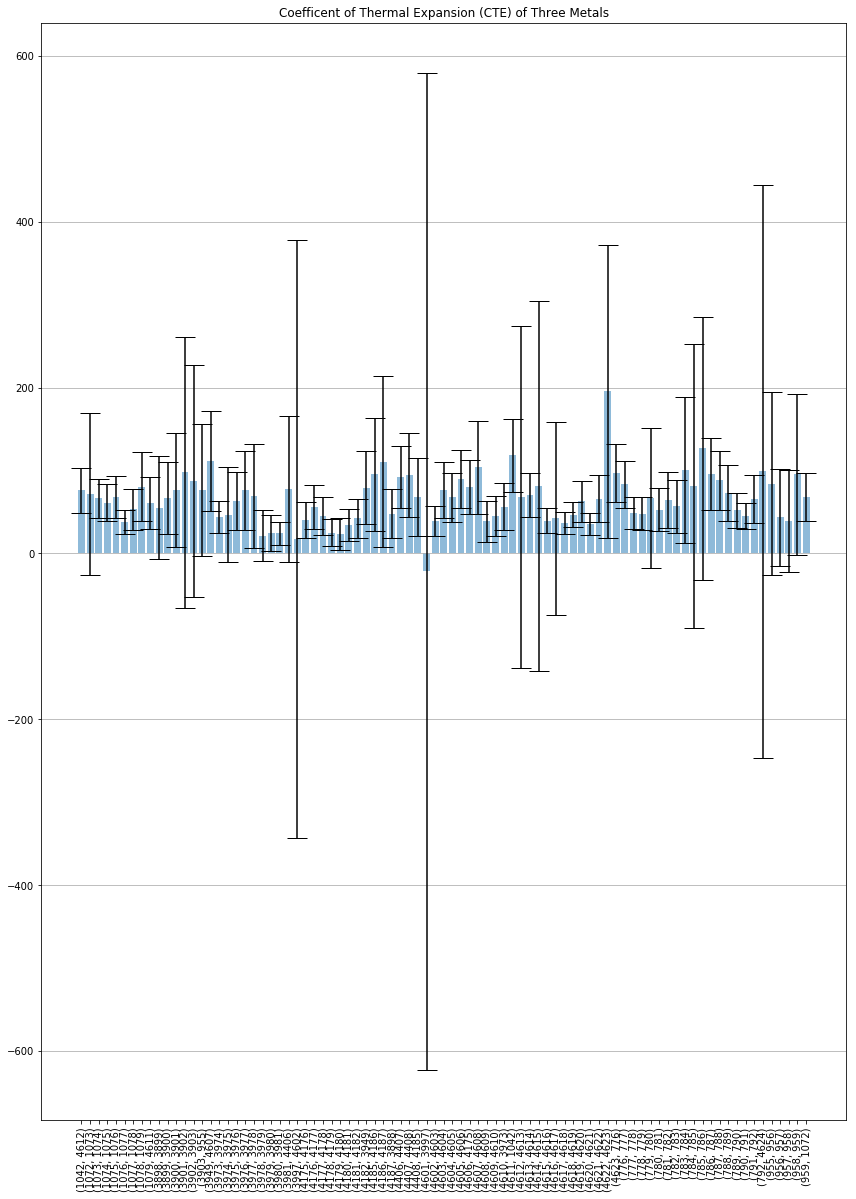

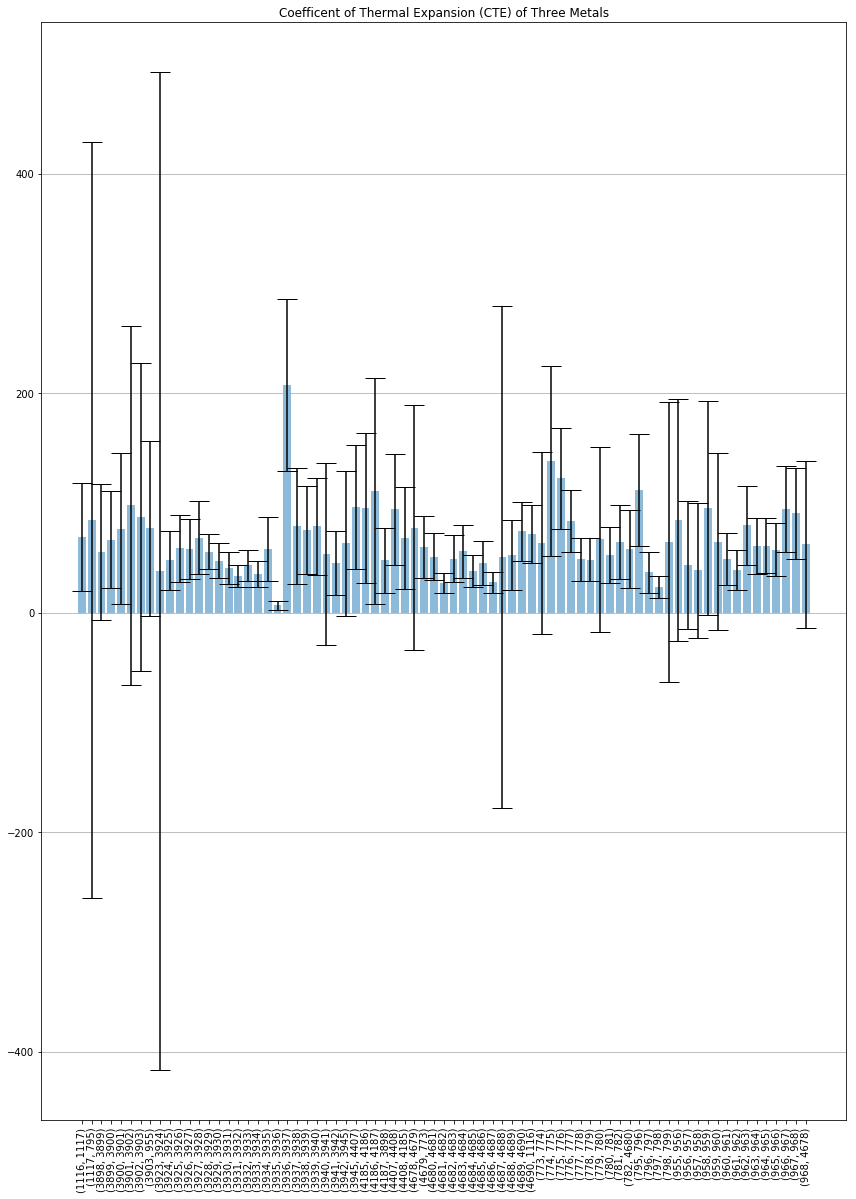

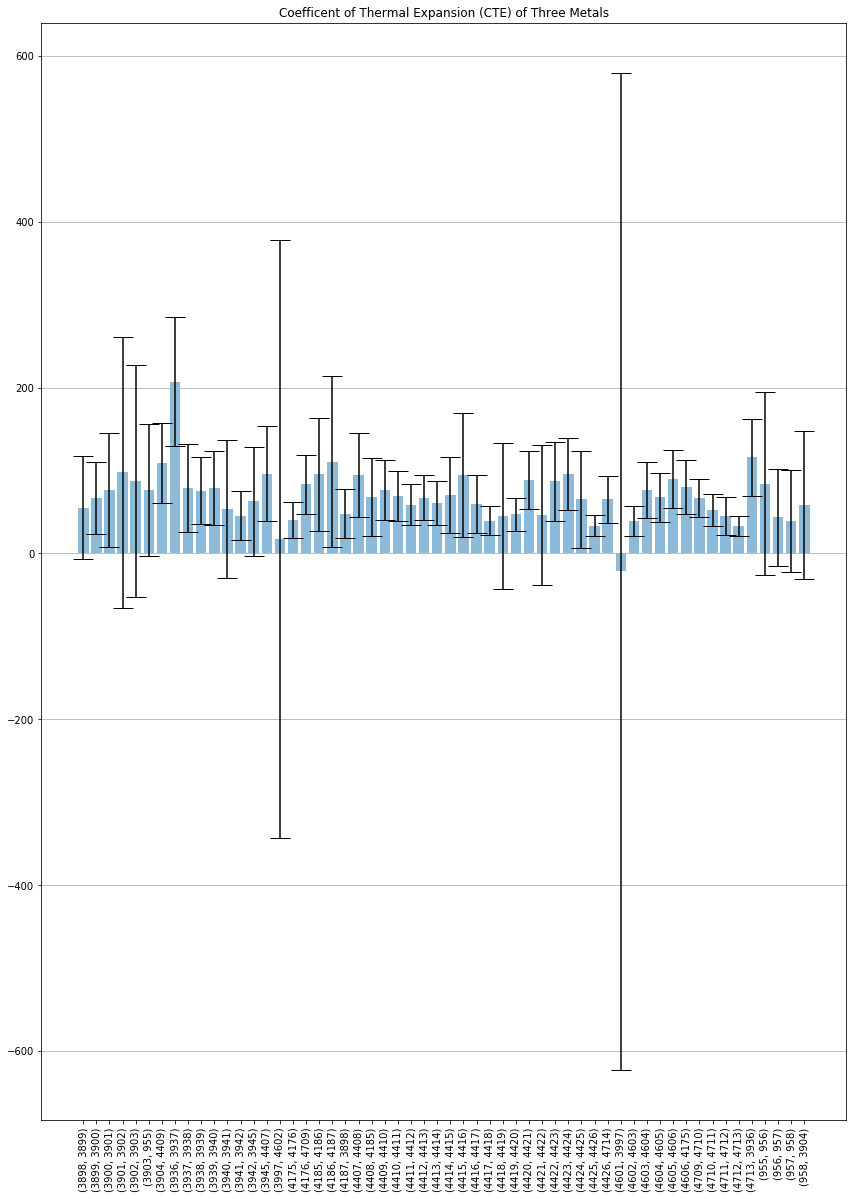

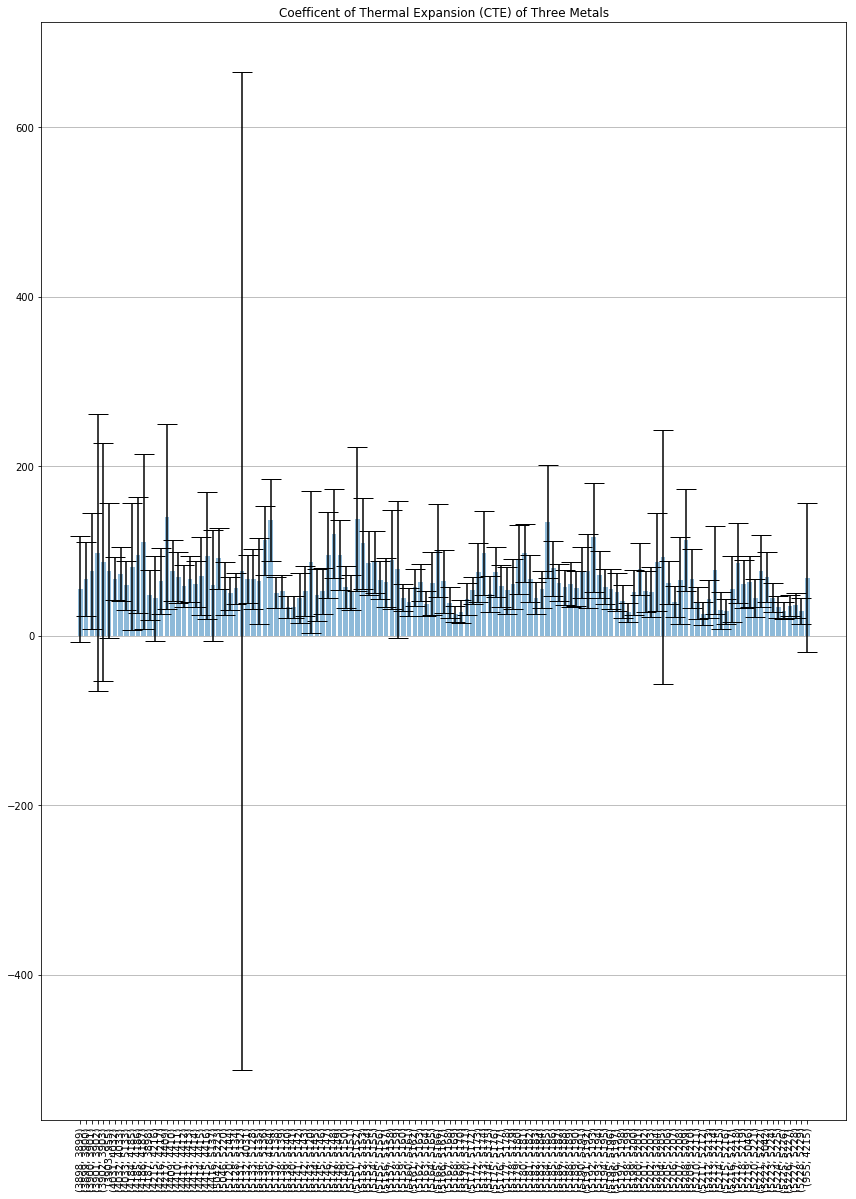

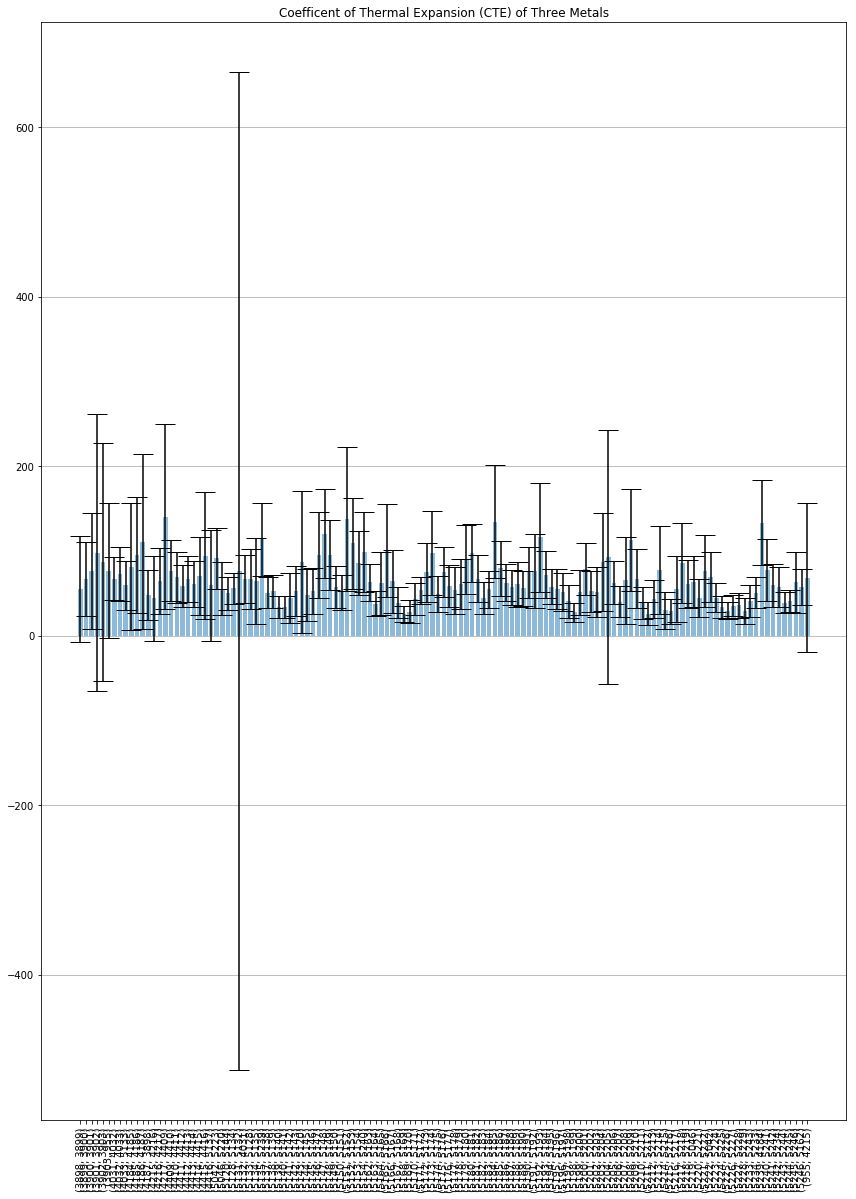

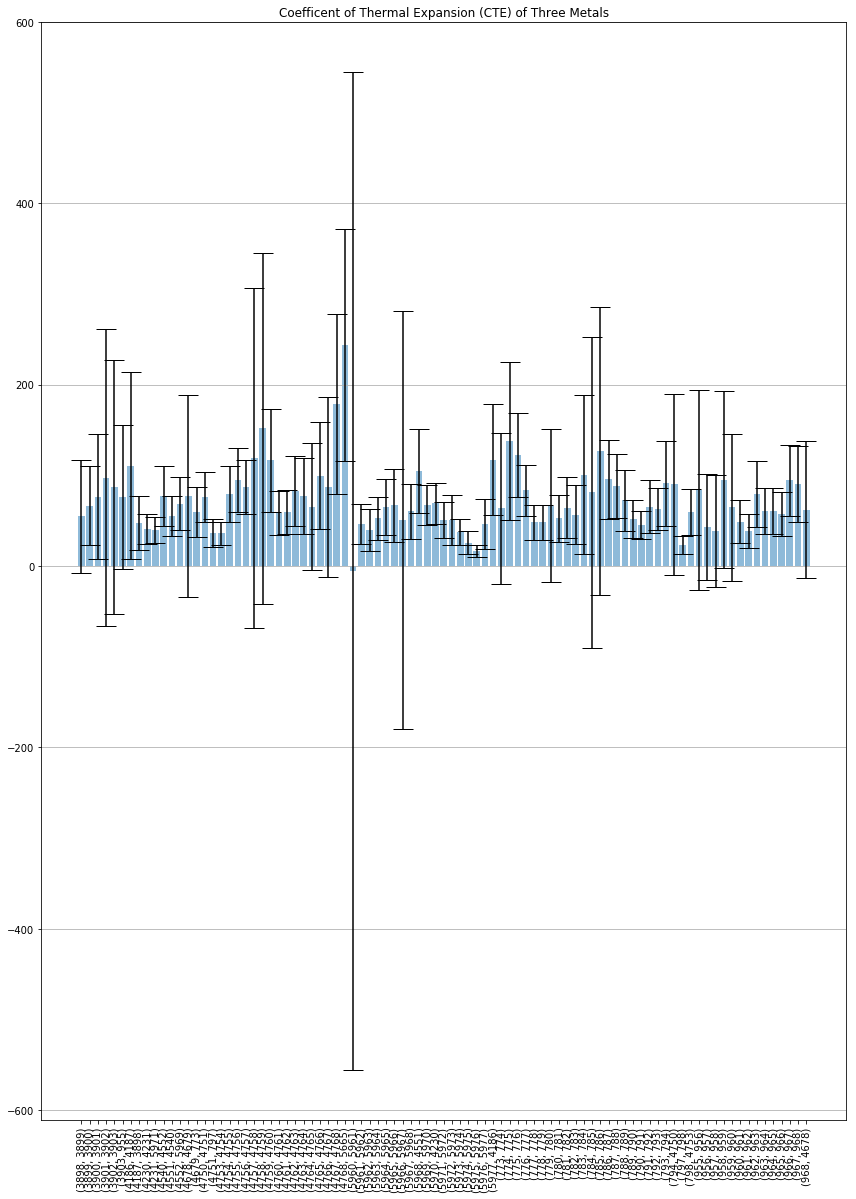

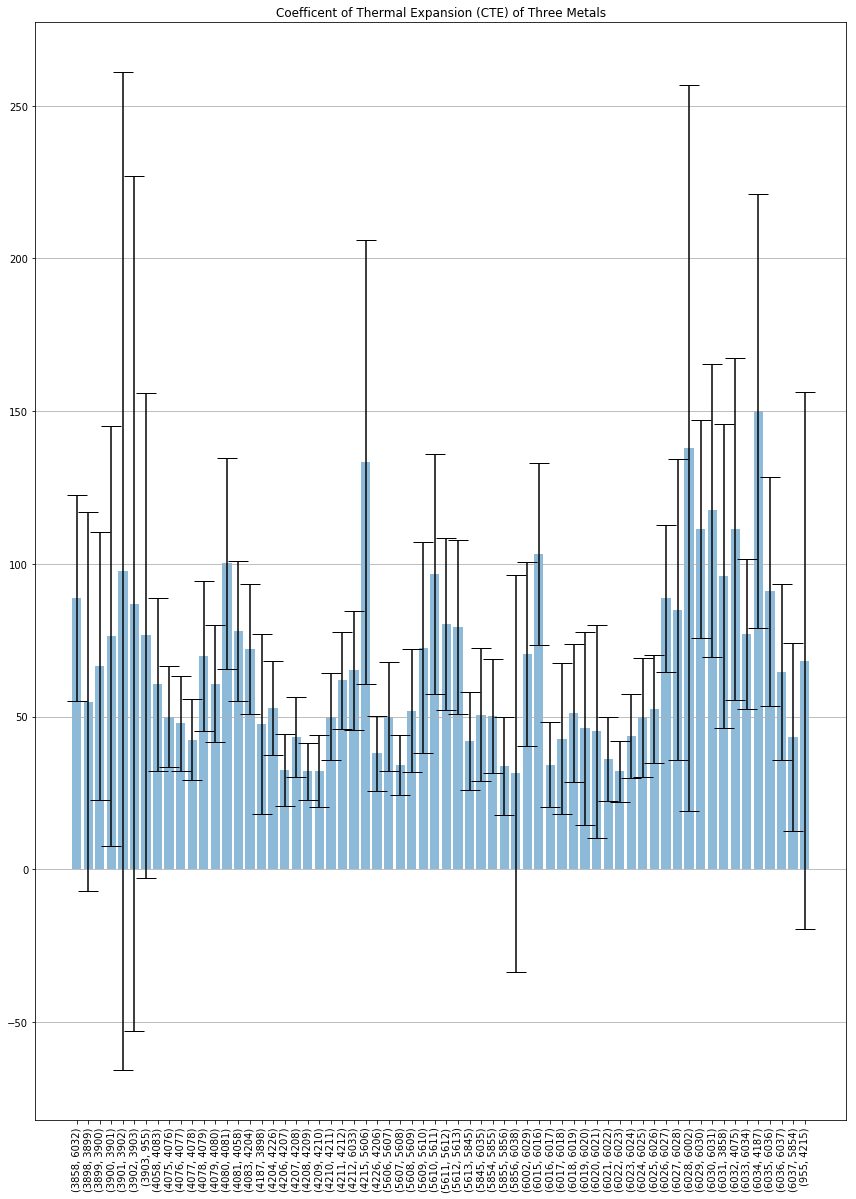

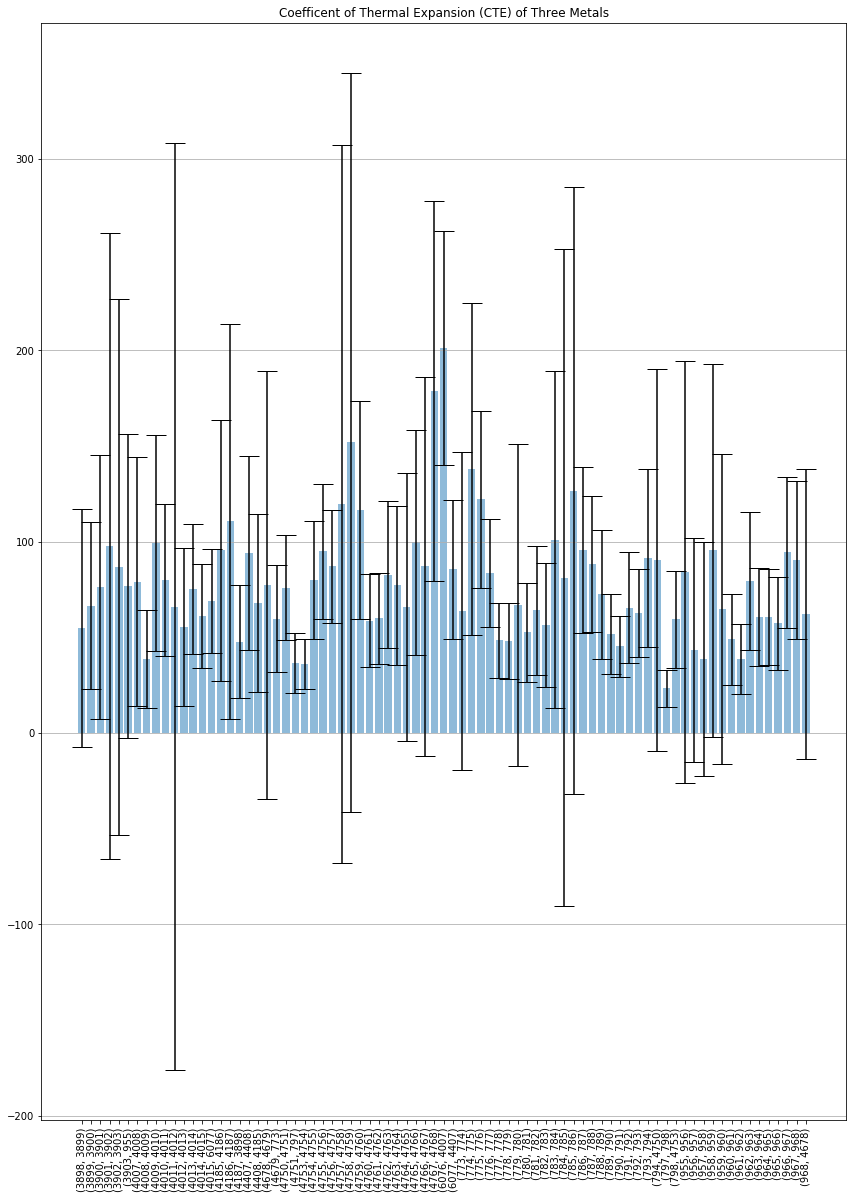

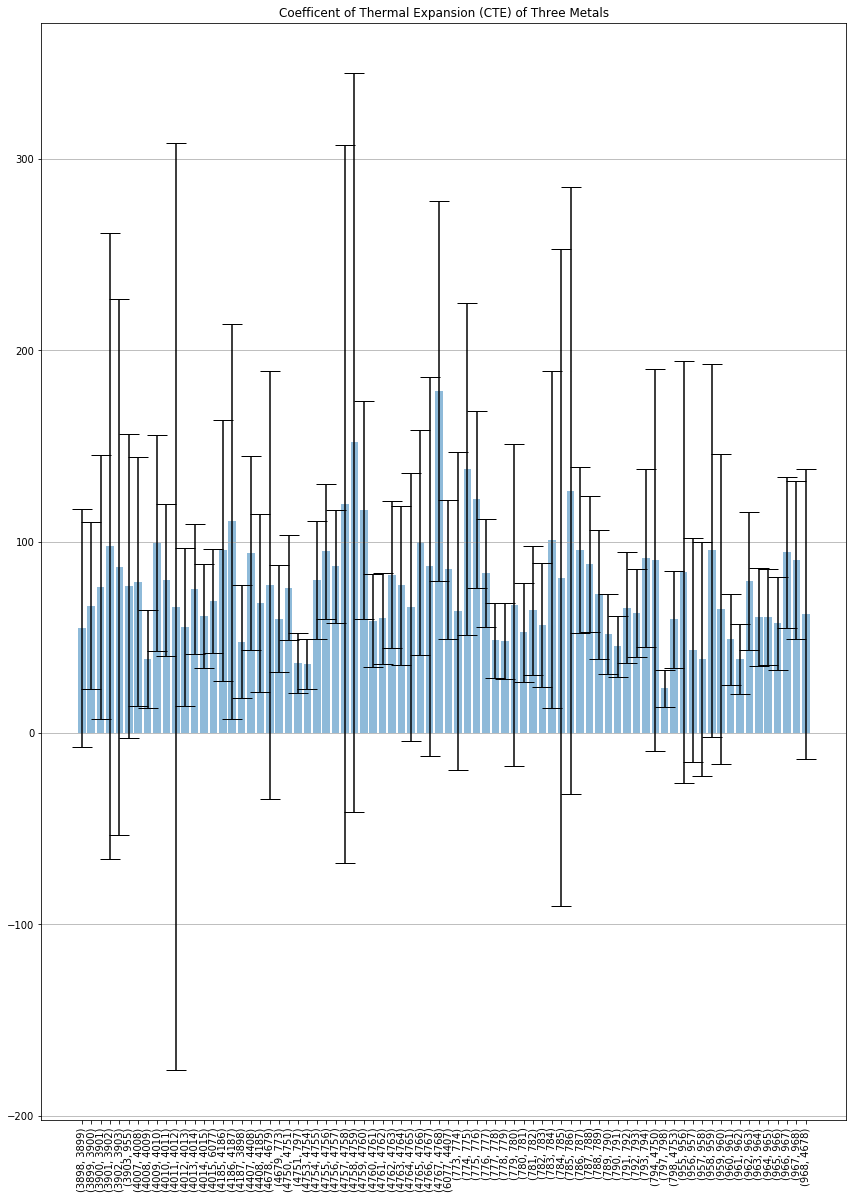

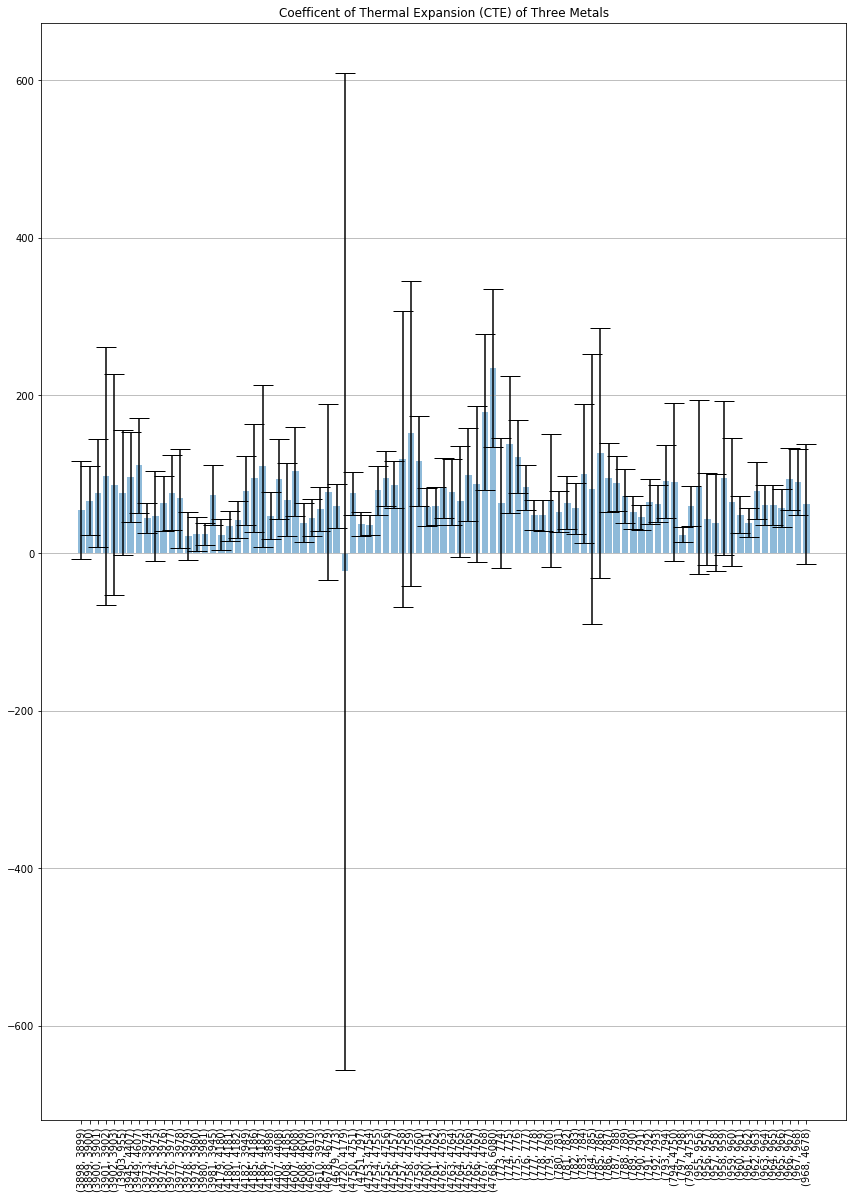

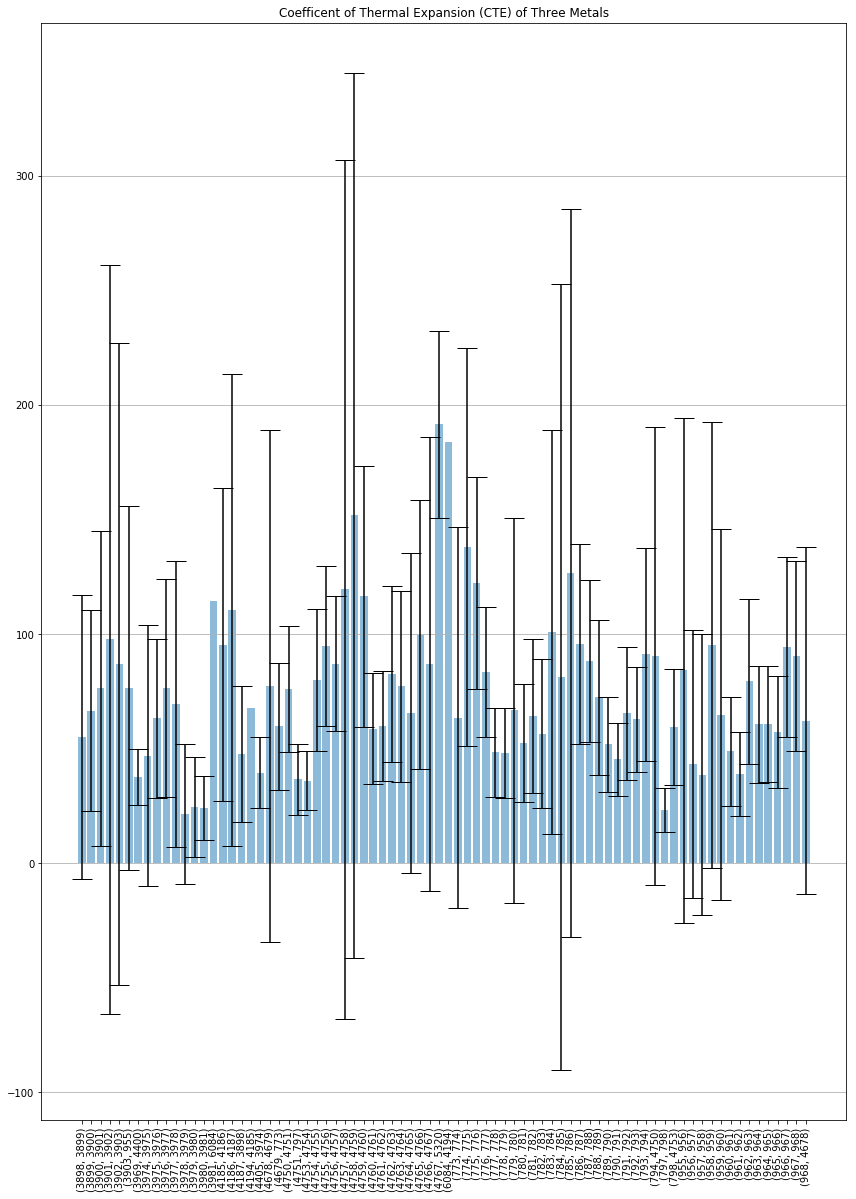

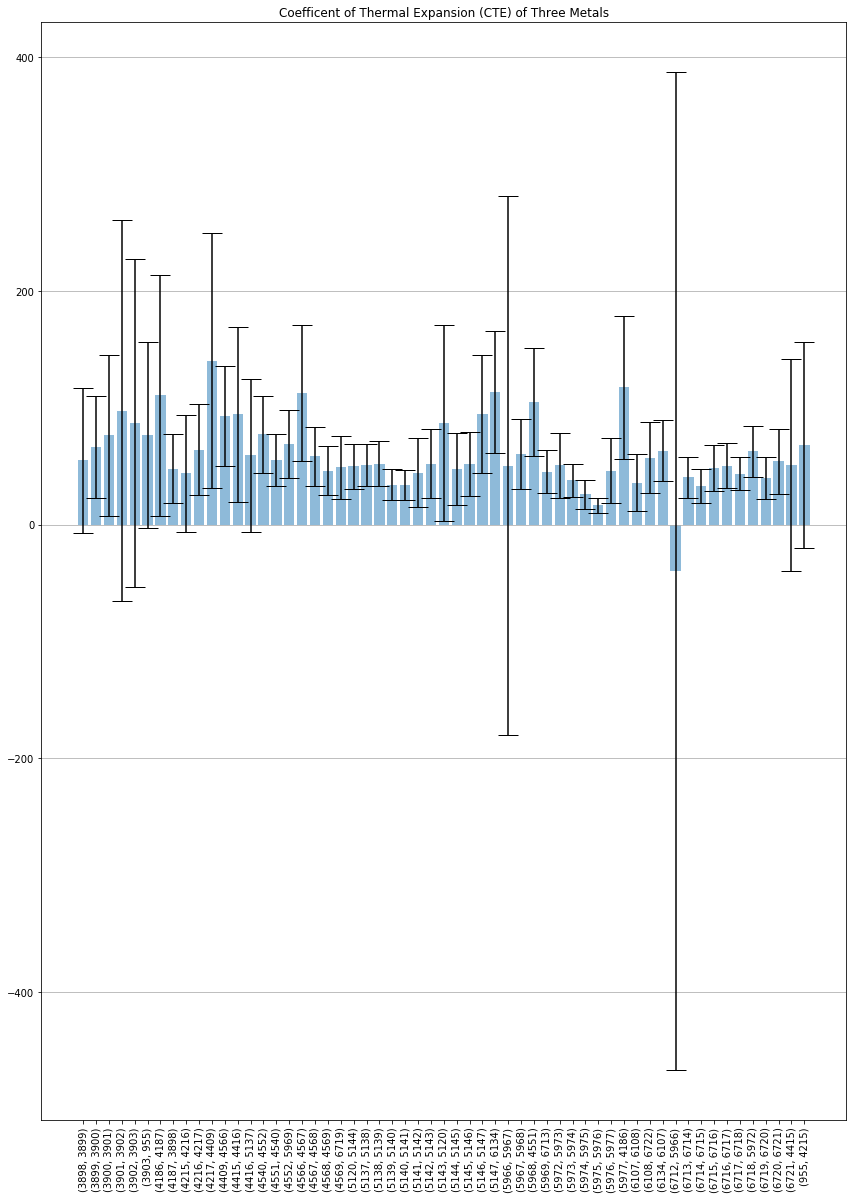

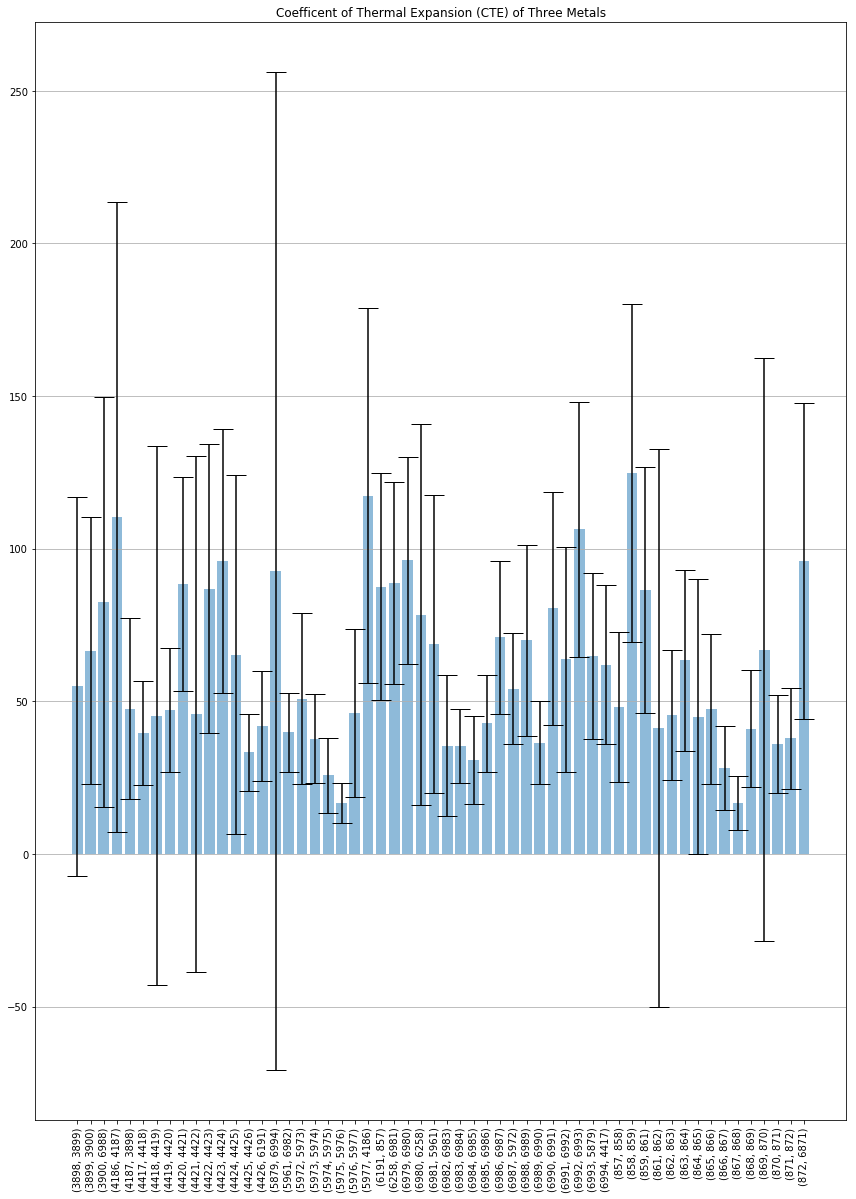

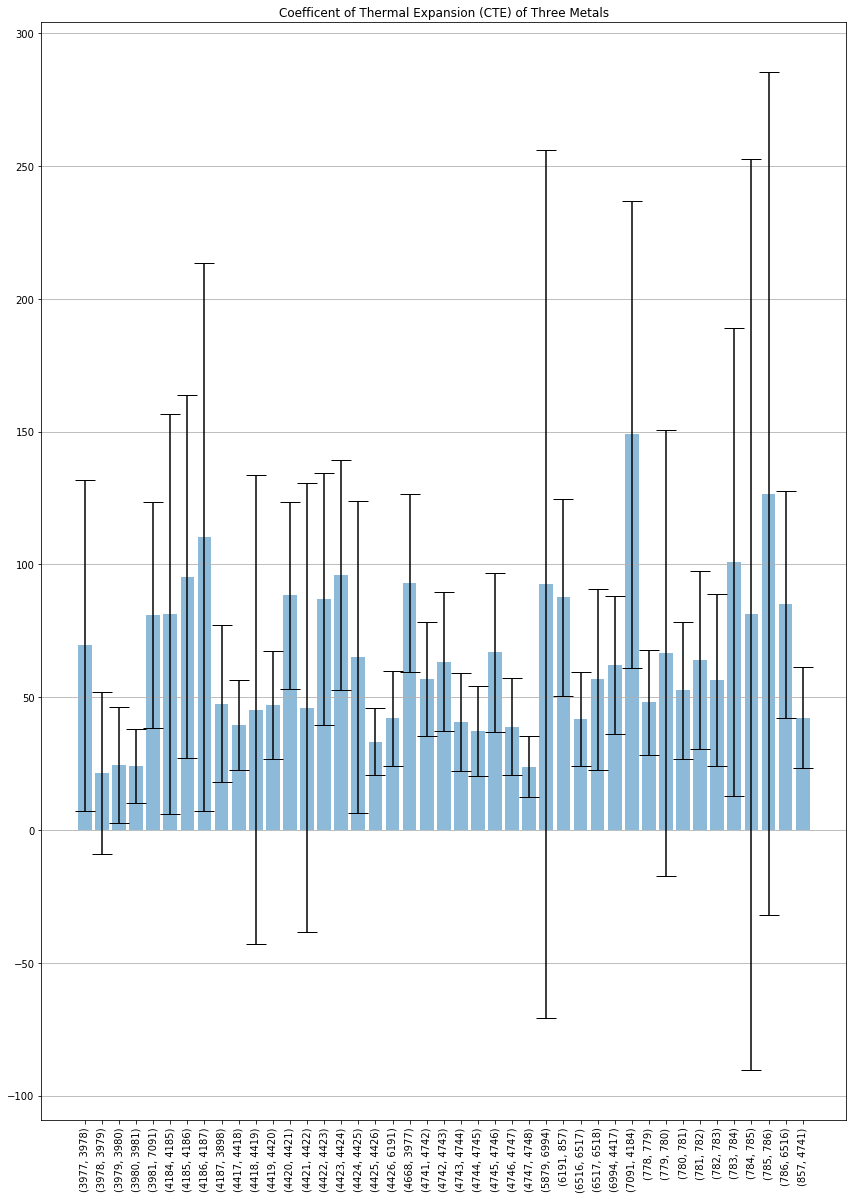

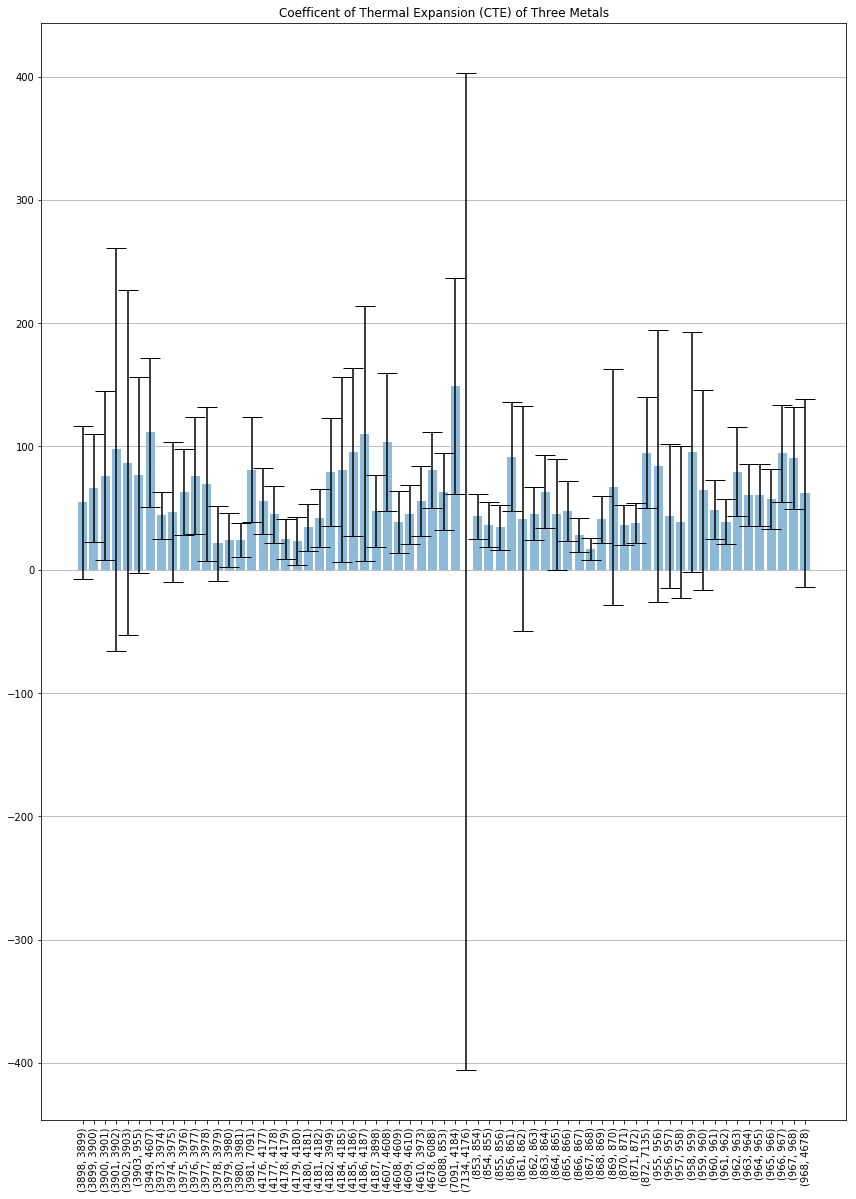

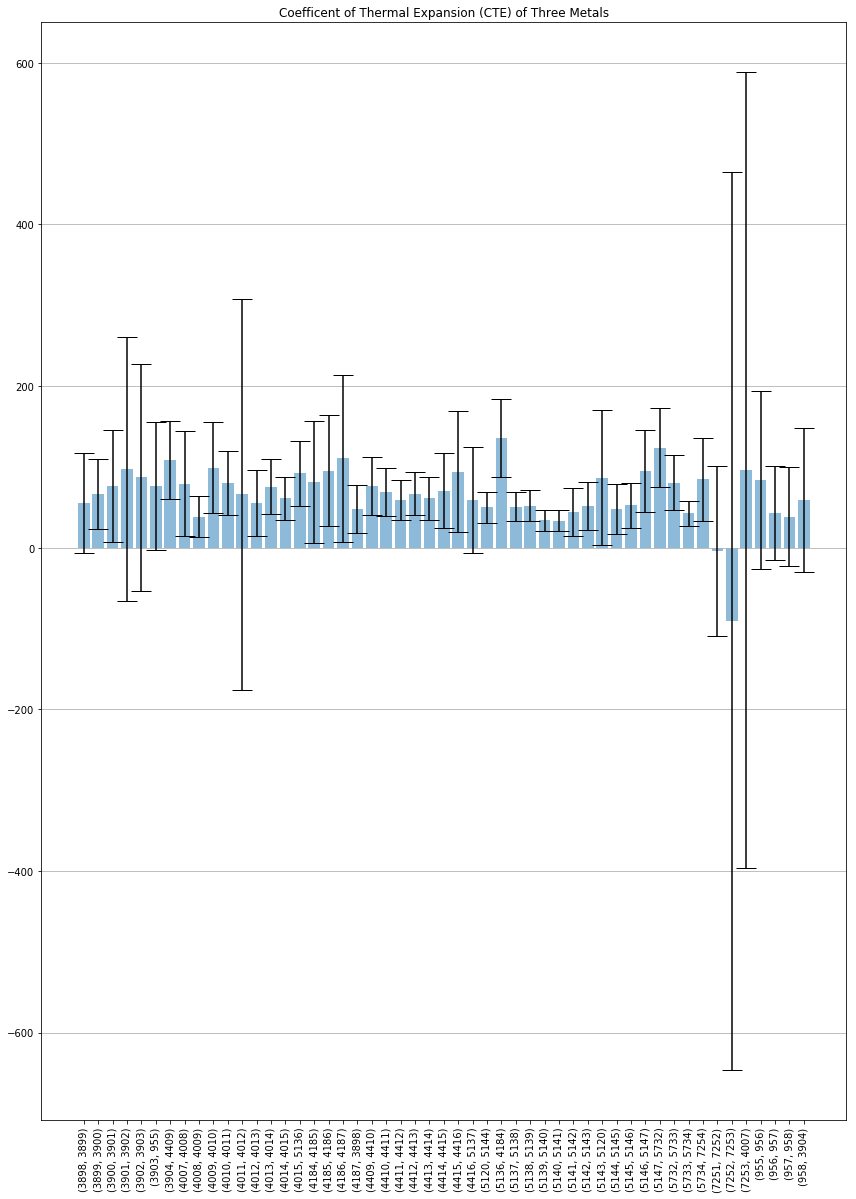

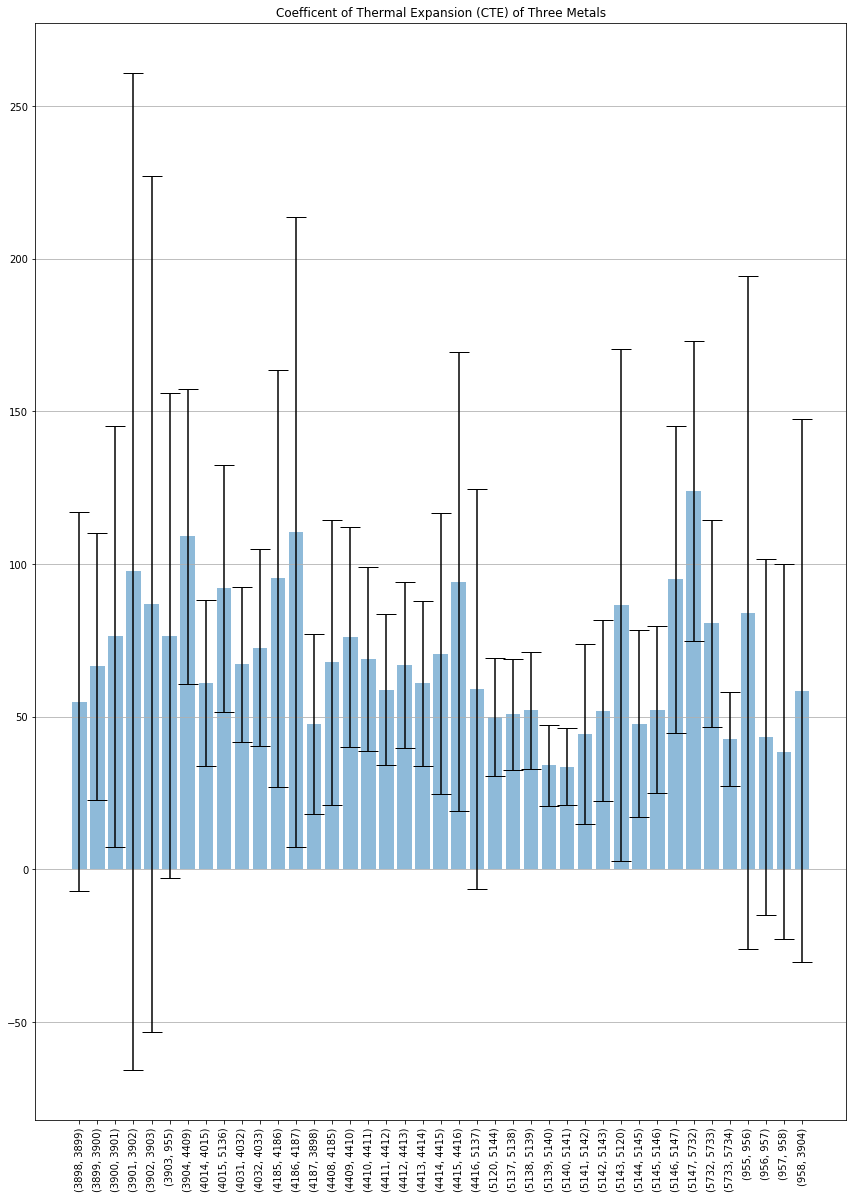

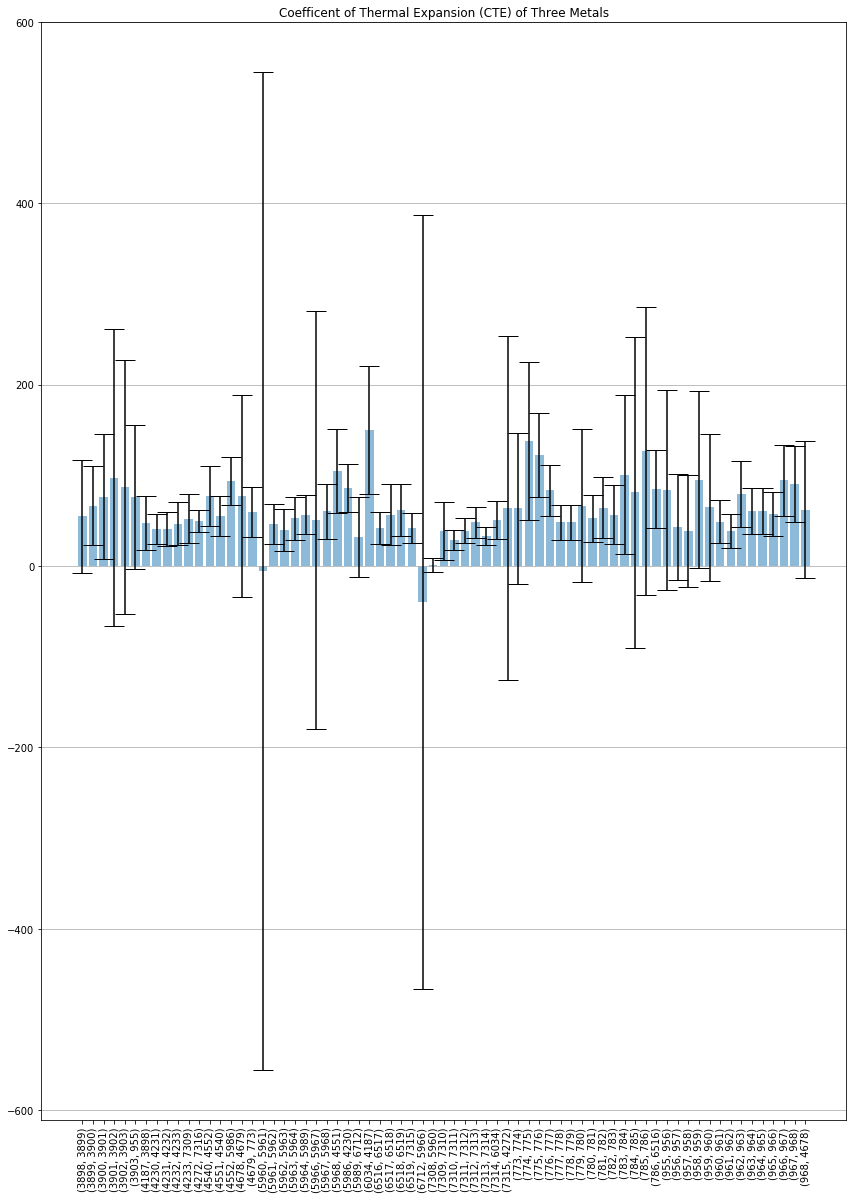

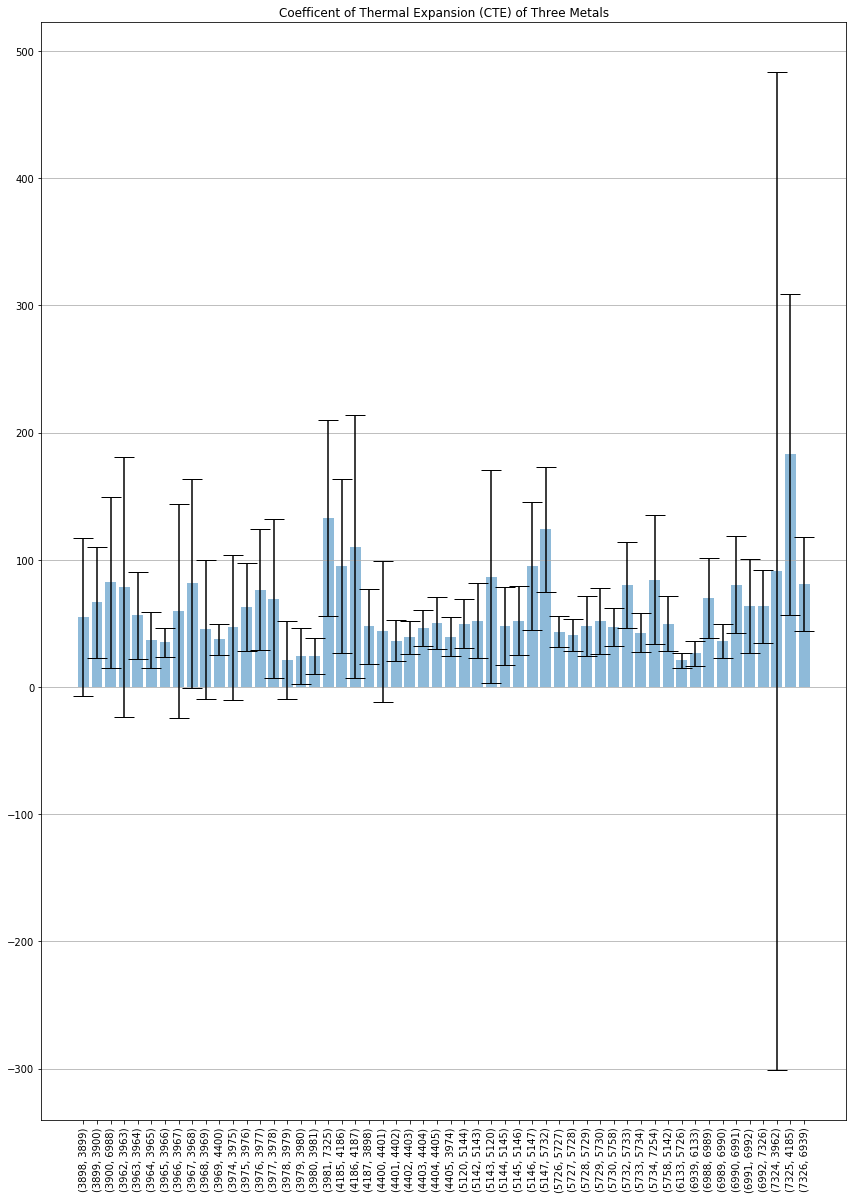

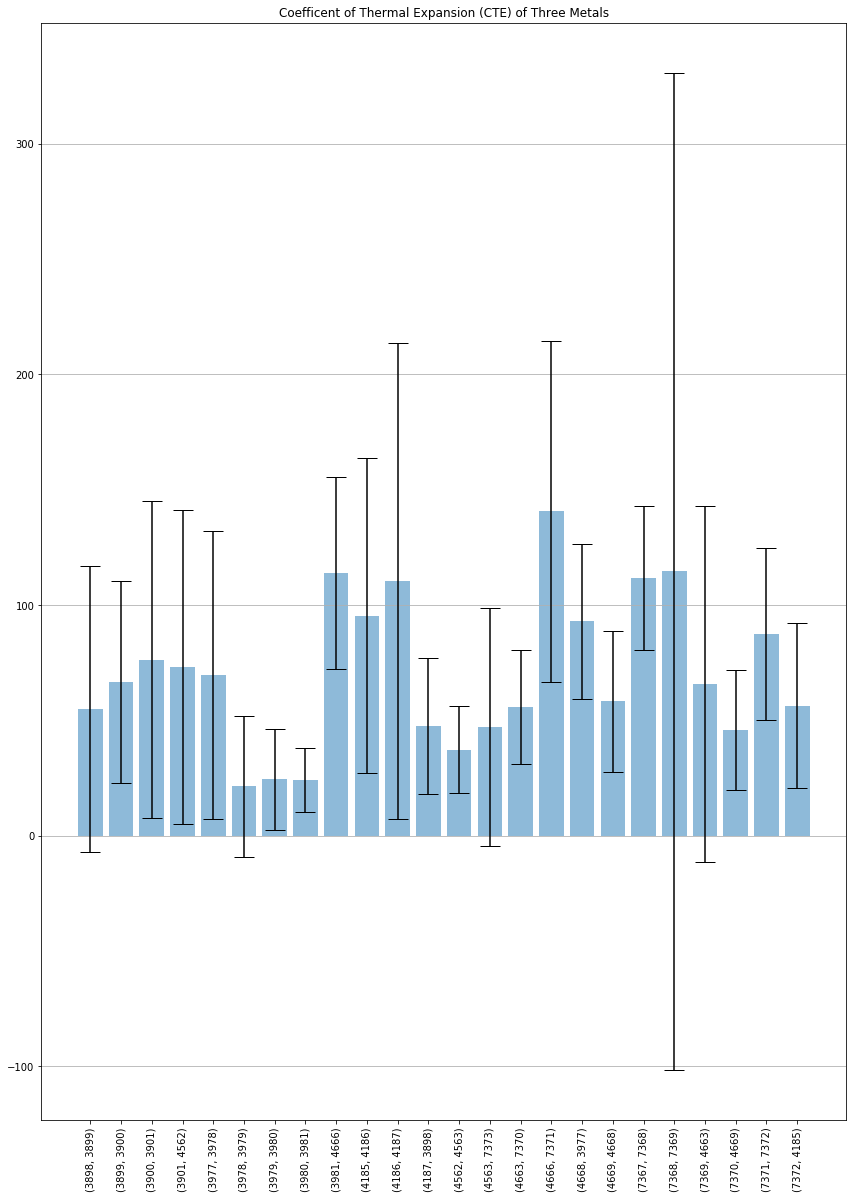

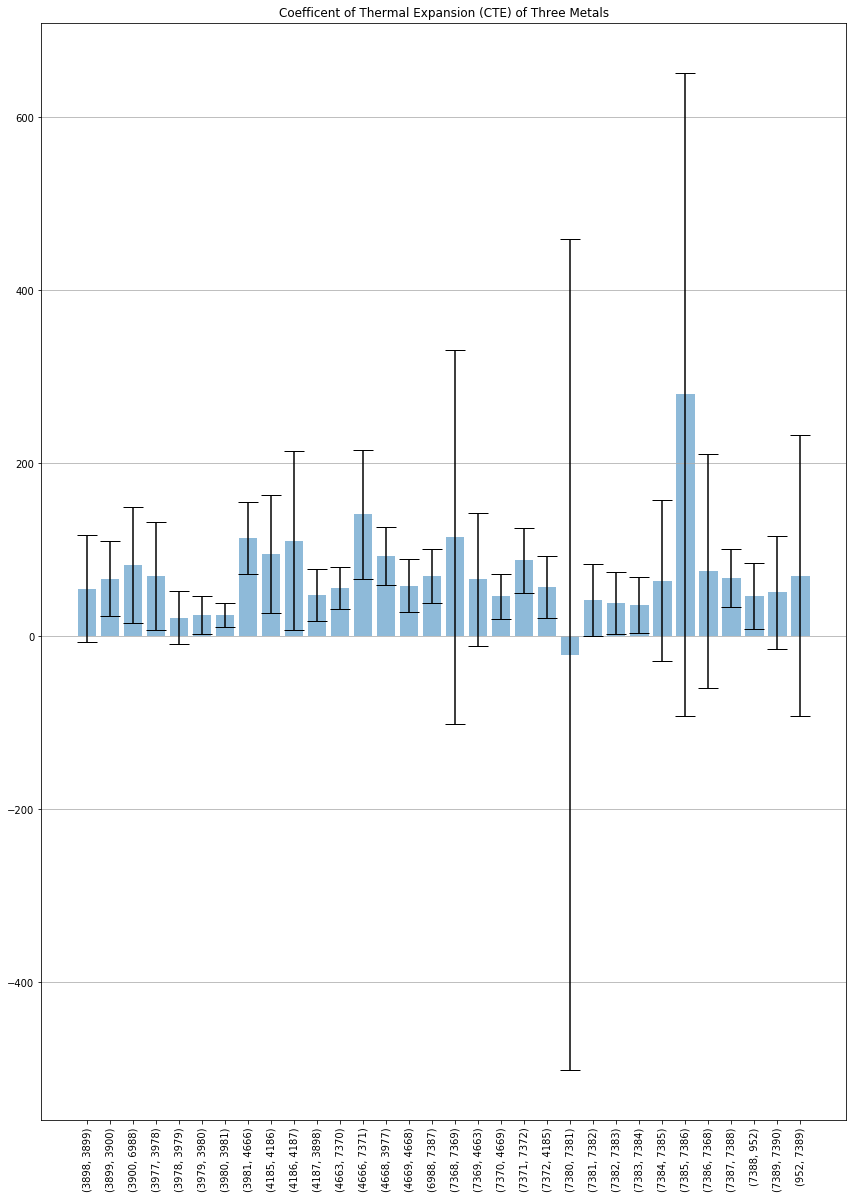

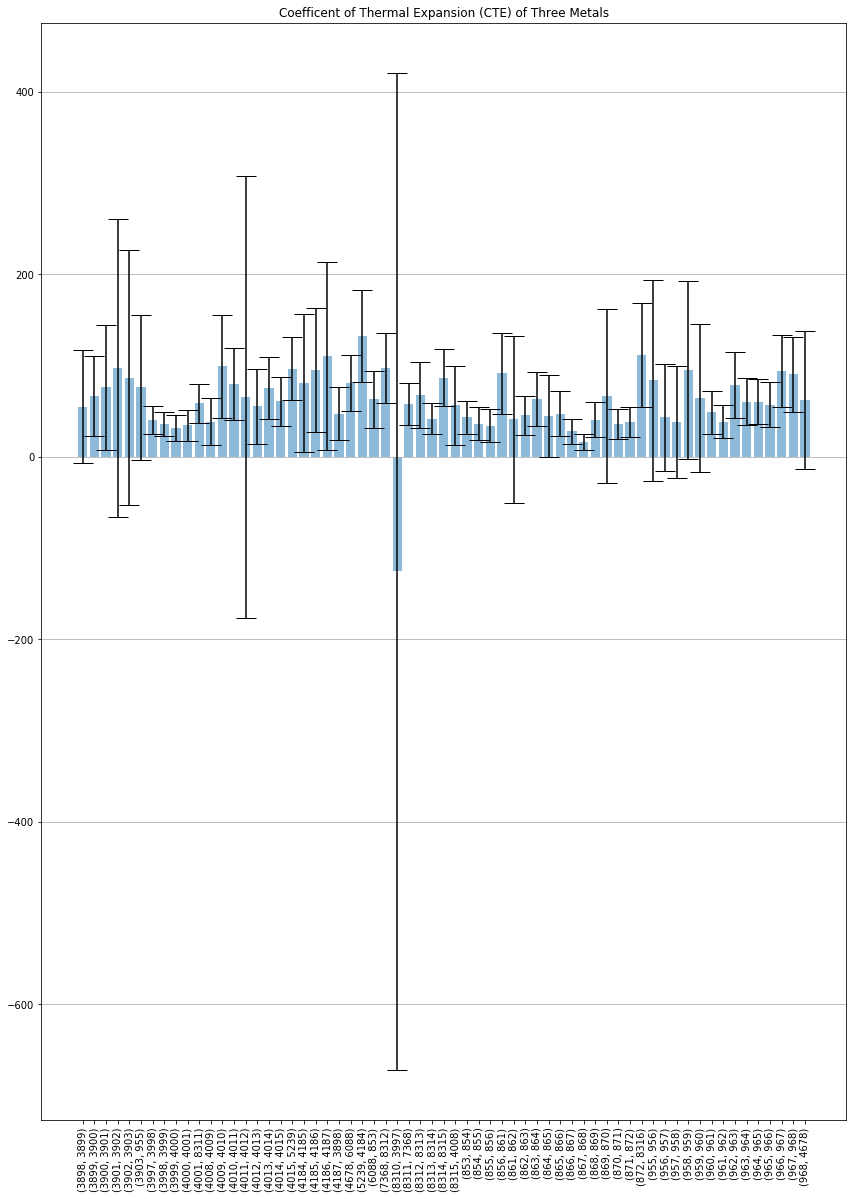

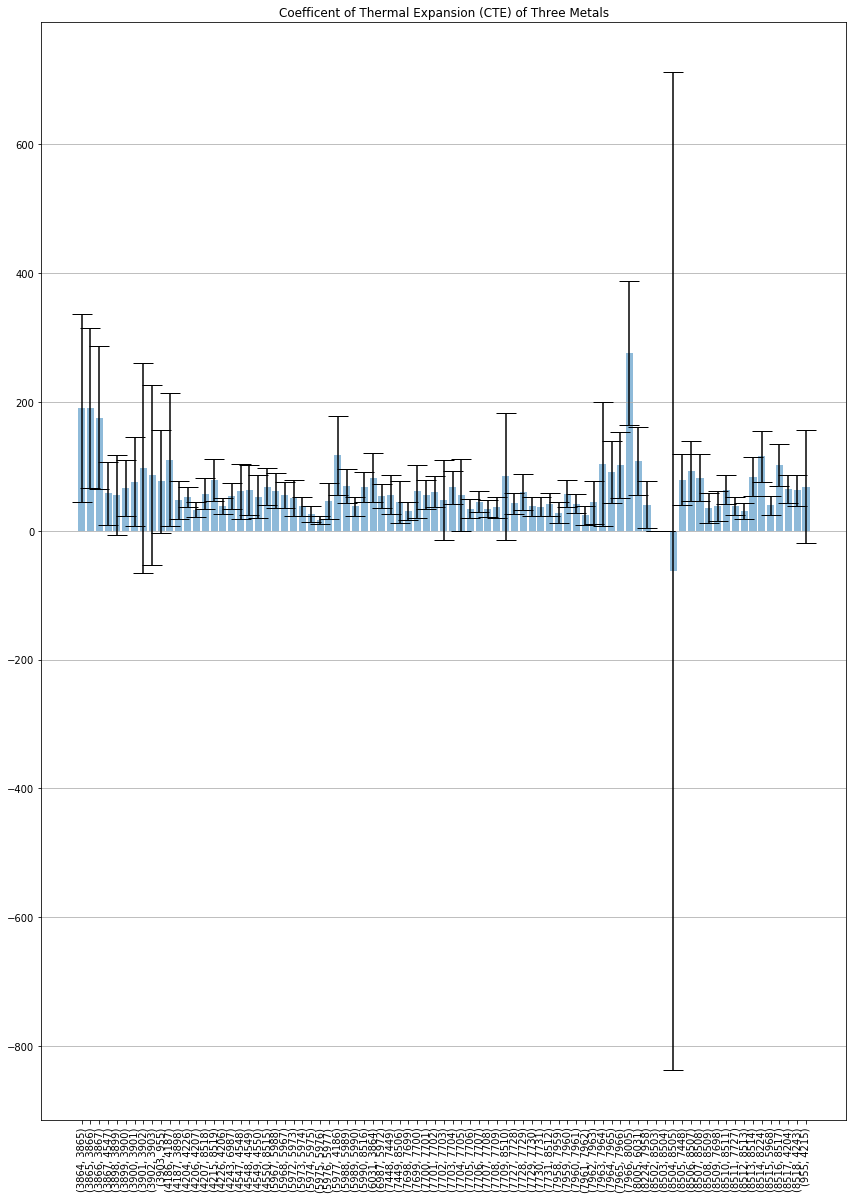

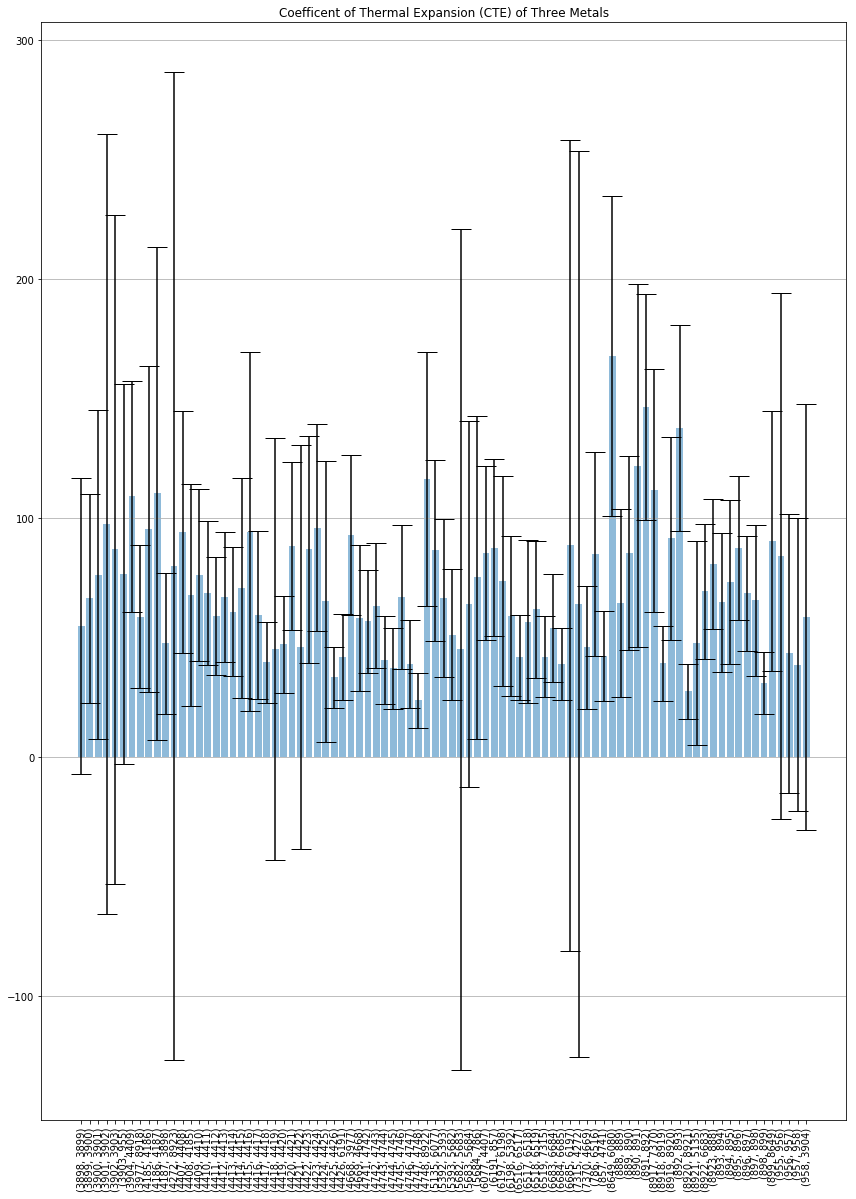

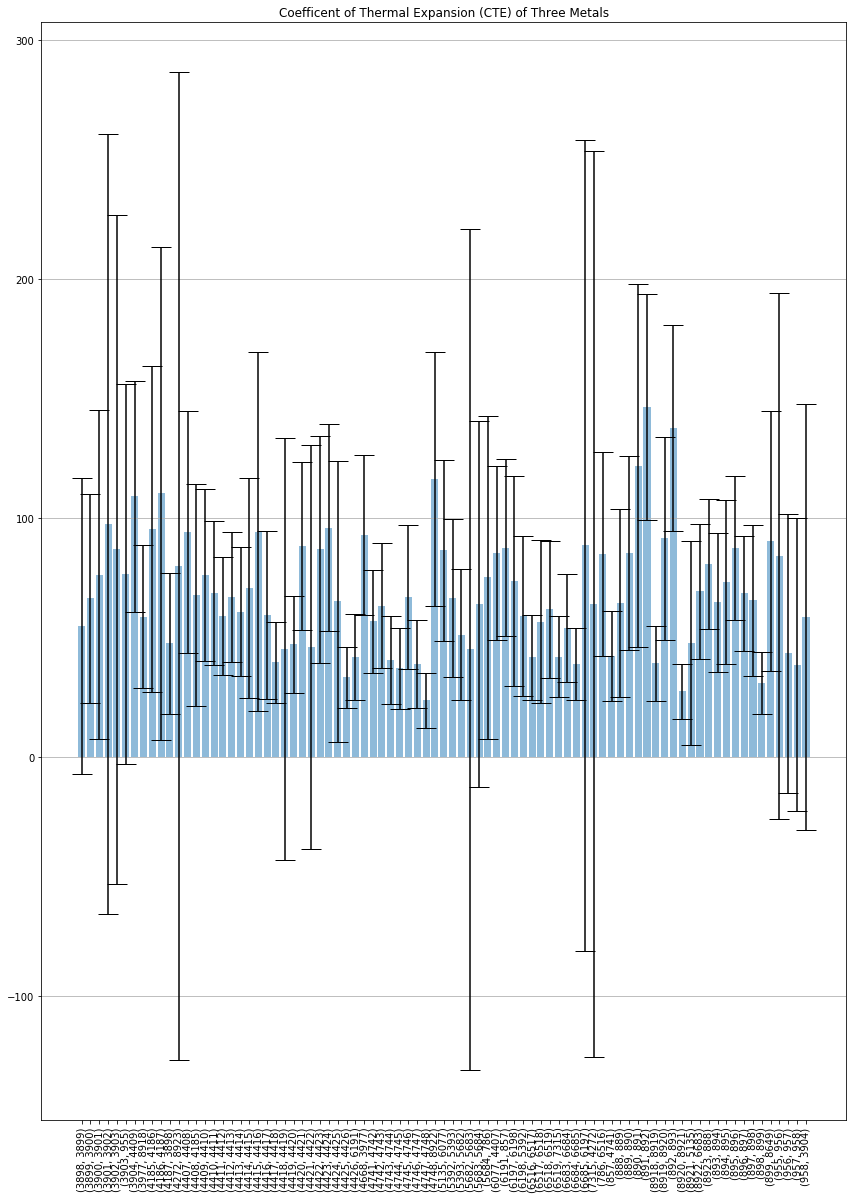

In [76]:
for line in range(0,len(linhas)):
# for line in range(0,1):   
    linktt = pd.DataFrame(columns=['_id', 'aproxlinkstart', 'hour', 'link', 'ltt', 
                               'month', 'travel_id', 'trip_id', 'weekday'])
    
    for iterated_link in range(0, len(linesedge[linhas[line]])):
    
#     for iterated_link in (range(0, 5)):
        with open('../../../../../GIT/smartbus/data/linktt/link-' + str(linesedge[linhas[line]][iterated_link]) + '.pkl', 'rb') as inputfile:  
            linktt_temp = pickle.load(inputfile)
            linktt = pd.concat([linktt_temp, linktt],sort=True)
            
    start_date = datetime.date(2017, 9, 1)       
    end_date = datetime.date(2017, 9, 28)  

    linktt['aproxlinkstart'] = pd.to_datetime(linktt['aproxlinkstart'], format = '%Y-%m-%d %H:%M:%S')
    linktt['day'] = pd.to_datetime(linktt['aproxlinkstart'], format = '%Y-%m-%d')
    
    linktt = linktt.loc[((linktt['aproxlinkstart'] >= start_date) &  
                     ((linktt['weekday'] == 3) |                  
                      (linktt['weekday'] == 4) | 
                      (linktt['weekday'] == 5)))
                   ]

    linktt.index = linktt['aproxlinkstart']
    
    linktt = linktt.iloc[linktt.index.indexer_between_time('08:00', '23:00')]
    
    # Define labels, positions, bar heights and error bar heights
    labels = np.array(linktt.groupby('link', as_index=True ).mean().reset_index()['link'])
    x_pos = np.arange(len(labels))
    CTEs = list(linktt.groupby('link', as_index=True ).mean()['ltt'].values)
    error = list(linktt.groupby('link', as_index=True ).std()['ltt'].values)


    # Build the plot
    fig, ax = plt.subplots(figsize = (12, 16))
    ax.bar(x_pos, CTEs,
           yerr=error,
           align='center',
           alpha=0.5,
           ecolor='black',
           capsize=10)

    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels)
    ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
    ax.yaxis.grid(True)


    # Save the figure and show
    plt.tight_layout()
    plt.xticks(rotation=90)
    plt.savefig('png/bar_mean_std_' + linhas[line]  + '.png')
    # plt.show()


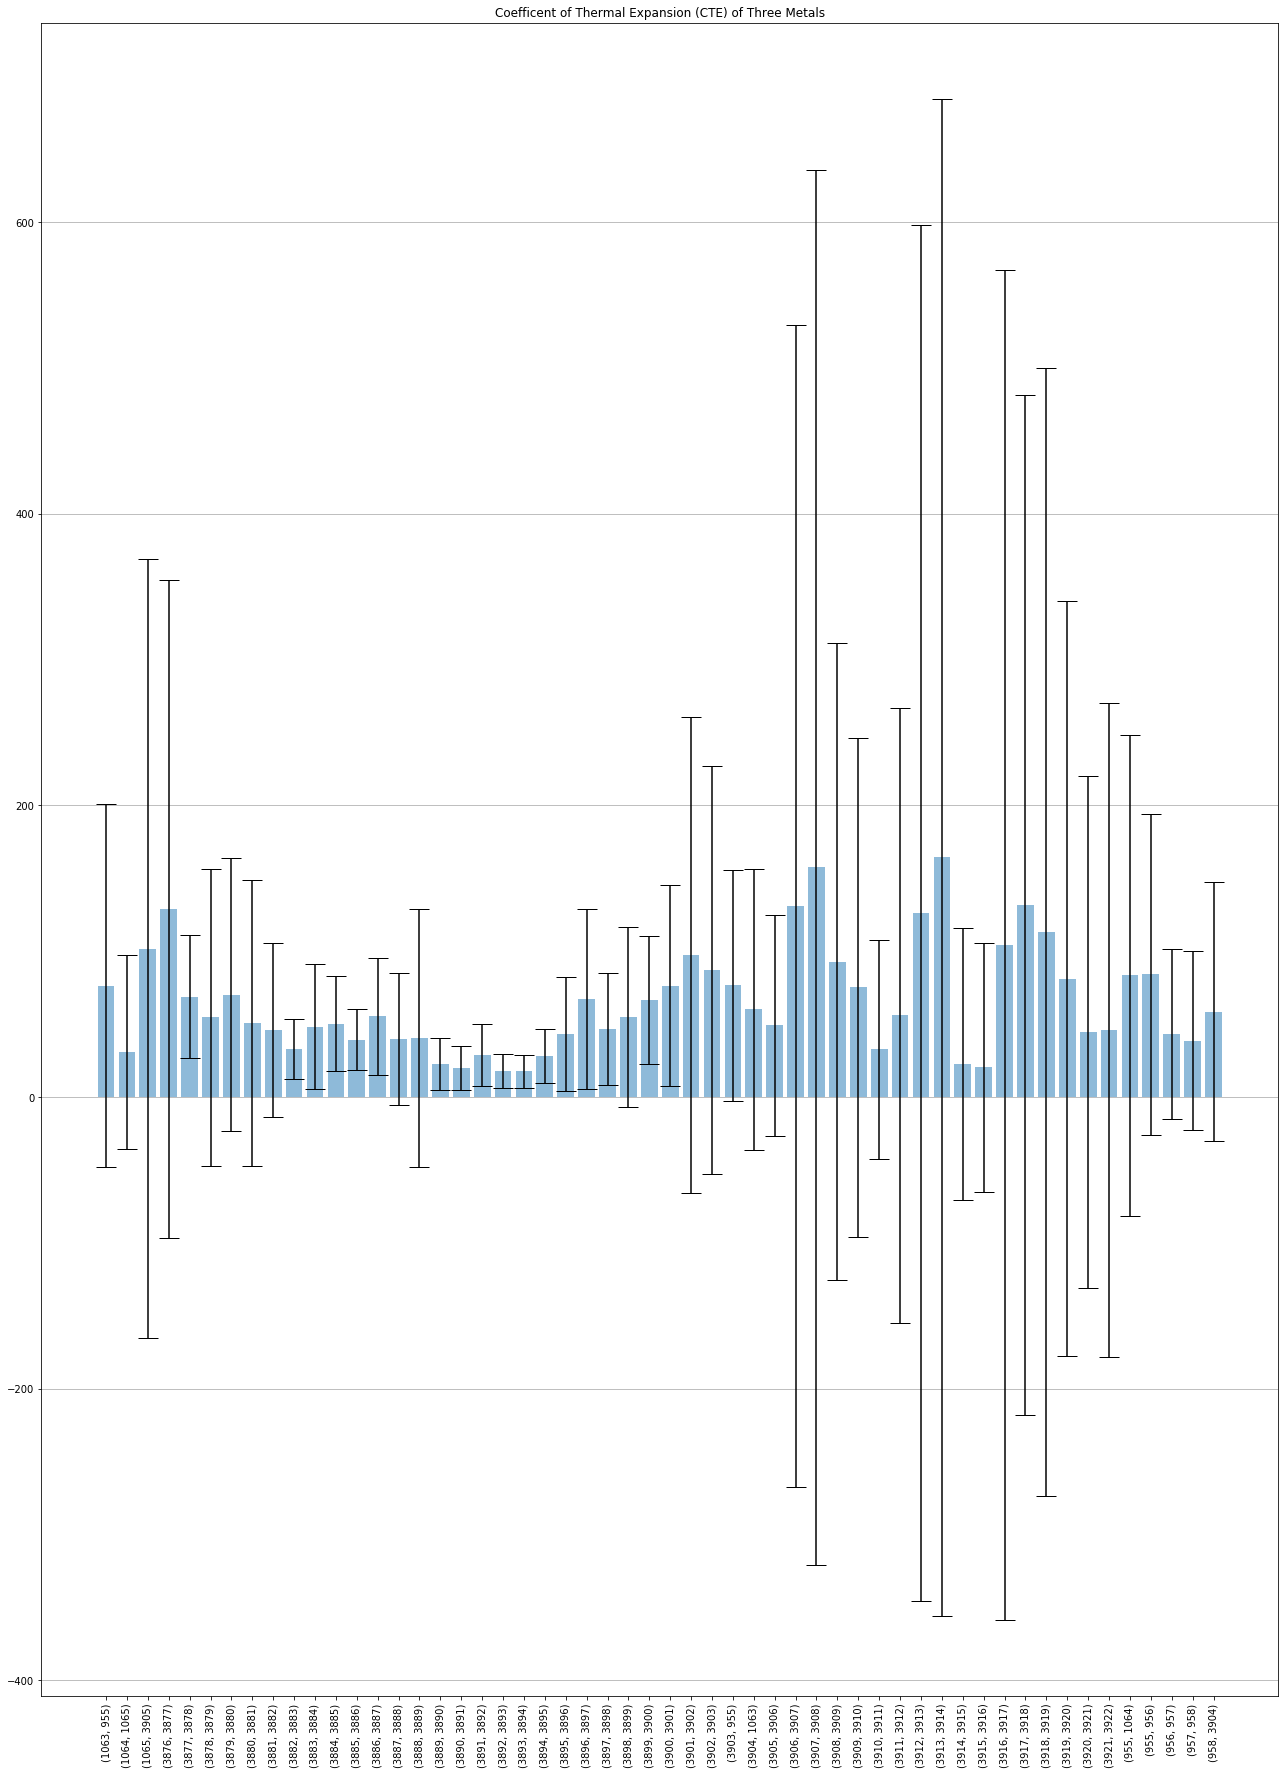

In [98]:

MAPE_day = []
    
for select_day in linktt.loc[linktt['aproxlinkstart'] >= end_date].aproxlinkstart.dt.strftime('%Y-%m-%d').unique():
    
    for link in range(1, len(linesedge[linhas[line]])-2):
#     for link in range(2, 7):
        df_temp = linktt.loc[(linktt['aproxlinkstart'] >= select_day) & 
                             (linktt['link'] == str(linesedge[linhas[line]][link]))
                            ]
    
        travels_day = np.unique(np.array(df_temp['travel_id']))

        for hour_day in range(480, 1260, 30):   
            int_part, float_part = divmod((hour_day/60), 1)

            if float_part != 0:
                hour_begin = str(int(int_part)) + ':' + '30'
                hour_end = str(int(int_part + 1 )) + ':' + '00'
                hour_test = str(int(int_part + 1 )) + ':' + '30'
                hour_future = str(int(int_part + 2 )) + ':' + '00'
            else:
                hour_begin = str(int(int_part)) + ':' + '00'
                hour_end = str(int(int_part)) + ':' + '30'
                hour_test = str(int(int_part + 1 )) + ':' + '00'
                hour_future = str(int(int_part + 1 )) + ':' + '30'

            df_temp_time = df_temp.iloc[df_temp.index.indexer_between_time( hour_begin, hour_end)]
            df_temp_test = df_temp.iloc[df_temp.index.indexer_between_time( hour_end, hour_test)]
            df_temp_future = df_temp.iloc[df_temp.index.indexer_between_time(hour_test, hour_future)]
            
            ### Temporal Link travel time used in the median (us) 
            temp_travels_time = df_temp_time['ltt']
            time_tests        = df_temp_test['ltt']
            time_future       = df_temp_future['ltt']
            

            median_test = np.median(temp_travels_time)                
           
            if ((len(temp_travels_time) > 0) & (math.isnan(median_test) == False)):
                MAPE_day.append([line, link, select_day, hour_begin + ' - ' + hour_end, len(temp_travels_time), 
                                 median_test, 
                                 mean_absolute_percentage_error([median_test]*len(temp_travels_time), temp_travels_time), 
                                 str(np.array(temp_travels_time)), 
                                 'Actual'])
                    
                MAPE_day.append([line, link, select_day, hour_end + ' - ' + hour_test, len(time_tests), 
                                 median_test,
                                 mean_absolute_percentage_error([median_test]*len(time_tests), time_tests), 
                                 str(np.array(time_tests)), 
                                 'After'])
                    
                MAPE_day.append([line, link, select_day, hour_test + ' - ' + hour_future, len(time_future), median_test,
                                     mean_absolute_percentage_error([median_test]*len(time_future), time_future), 
                                     str(np.array(time_future)), 'Future'])

                
data = pd.DataFrame(MAPE_day,columns=['line', 'link', 'day', 'time', 'N-travel', 'median', 'MAPE', 
                                      'travels_time', 'errors'])
# data = data.loc[data['MAPE'] != 0] 

pd.DataFrame(data).to_html('html/data-30M_median_'  + select_day + '.html')  
        
# data = data.loc[data['MAPE'] != 0]

# data.loc[(data['errors'] != 'median_LR_after') & (data['errors'] != 'median_Tree_after') &
#         (data['errors'] != 'median_LR_future') & (data['errors'] != 'median_Tree_future')]

fig = (
        p9.ggplot(data, p9.aes(x = 'errors', y ='MAPE', group='errors', colors='errors')) +
        p9.geom_boxplot( outlier_shape = "") +
        p9.scale_y_continuous(limits =  (0, 50)) +        
        p9.stat_boxplot(geom ='errorbar')  +        
        p9.theme_bw() +
        p9.theme(figure_size = (8, 12)) +
        p9.facet_wrap('~line', ncol = 3) +
        p9.labs(title = 'MAPE of the lines in the day ' + select_day ) +
        p9.theme(figure_size = (9, 12)) +
        p9.theme(axis_text_x = p9.element_text(angle=90)) 
    )
p9.ggsave(fig, 'png/Boxplot' + '_' + select_day + '_30M_median.png')  
p9.ggsave(fig, 'pdf/Boxplot' + '_' + select_day + '_30M_median.pdf')  


for i in data['errors'].unique():
    print(i + ' : ' + str(data.loc[data['errors'] == i]['MAPE'].mean()))


Actual : 52.73548280974722
After : 323.4832612215392
Future : 261.7892941970716


In [99]:

MAPE_day = []
    
for select_day in linktt.loc[linktt['aproxlinkstart'] >= end_date].aproxlinkstart.dt.strftime('%Y-%m-%d').unique():
    
    for link in range(1, len(linesedge[linhas[line]])-2):
#     for link in range(2, 7):
        df_temp = linktt.loc[(linktt['aproxlinkstart'] >= select_day) & 
                             (linktt['link'] == str(linesedge[linhas[line]][link]))
                            ]
    
        travels_day = np.unique(np.array(df_temp['travel_id']))

        for hour_day in range(480, 1260, 30):   
            int_part, float_part = divmod((hour_day/60), 1)

            if float_part != 0:
                hour_begin = str(int(int_part)) + ':' + '30'
                hour_end = str(int(int_part + 1 )) + ':' + '00'
                hour_test = str(int(int_part + 1 )) + ':' + '30'
                hour_future = str(int(int_part + 2 )) + ':' + '00'
            else:
                hour_begin = str(int(int_part)) + ':' + '00'
                hour_end = str(int(int_part)) + ':' + '30'
                hour_test = str(int(int_part + 1 )) + ':' + '00'
                hour_future = str(int(int_part + 1 )) + ':' + '30'

            df_temp_time = df_temp.iloc[df_temp.index.indexer_between_time( hour_begin, hour_end)]
            df_temp_test = df_temp.iloc[df_temp.index.indexer_between_time( hour_end, hour_test)]
            df_temp_future = df_temp.iloc[df_temp.index.indexer_between_time(hour_test, hour_future)]
            
            ### Temporal Link travel time used in the median (us) 
            temp_travels_time = df_temp_time['ltt']
            time_tests        = df_temp_test['ltt']
            time_future       = df_temp_future['ltt']
            

            median_test = np.mean(temp_travels_time)                
           
            if ((len(temp_travels_time) > 0) & (math.isnan(median_test) == False)):
                MAPE_day.append([line, link, select_day, hour_begin + ' - ' + hour_end, len(temp_travels_time), 
                                 median_test, 
                                 mean_absolute_percentage_error([median_test]*len(temp_travels_time), temp_travels_time), 
                                 str(np.array(temp_travels_time)), 
                                 'Actual'])
                    
                MAPE_day.append([line, link, select_day, hour_end + ' - ' + hour_test, len(time_tests), 
                                 median_test,
                                 mean_absolute_percentage_error([median_test]*len(time_tests), time_tests), 
                                 str(np.array(time_tests)), 
                                 'After'])
                    
                MAPE_day.append([line, link, select_day, hour_test + ' - ' + hour_future, len(time_future), median_test,
                                     mean_absolute_percentage_error([median_test]*len(time_future), time_future), 
                                     str(np.array(time_future)), 'Future'])

                
data = pd.DataFrame(MAPE_day,columns=['line', 'link', 'day', 'time', 'N-travel', 'median', 'MAPE', 
                                      'travels_time', 'errors'])
# data = data.loc[data['MAPE'] != 0] 

pd.DataFrame(data).to_html('html/data-30M_mean_'  + select_day + '.html')  
        
# data = data.loc[data['MAPE'] != 0]

# data.loc[(data['errors'] != 'median_LR_after') & (data['errors'] != 'median_Tree_after') &
#         (data['errors'] != 'median_LR_future') & (data['errors'] != 'median_Tree_future')]

fig = (
        p9.ggplot(data, p9.aes(x = 'errors', y ='MAPE', group='errors', colors='errors')) +
        p9.geom_boxplot( outlier_shape = "") +
#         p9.scale_y_continuous(limits =  (0, 50)) +        
        p9.stat_boxplot(geom ='errorbar')  +        
        p9.theme_bw() +
        p9.theme(figure_size = (8, 12)) +
        p9.facet_wrap('~line', ncol = 3) +
        p9.labs(title = 'MAPE of the lines in the day ' + select_day ) +
        p9.theme(figure_size = (9, 12)) +
        p9.theme(axis_text_x = p9.element_text(angle=90)) 
    )
p9.ggsave(fig, 'png/Boxplot' + '_' + select_day + '_30M_mean.png')  
p9.ggsave(fig, 'pdf/Boxplot' + '_' + select_day + '_30M_mean.pdf')  


for i in data['errors'].unique():
    print(i + ' : ' + str(data.loc[data['errors'] == i]['MAPE'].mean()))


Actual : 31.874030015372625
After : 291.6129596409533
Future : 189.0730073025666


# Using the Median and Mean of $n$ buses in a period of 60 minutes

In [101]:

MAPE_day = []
    
for select_day in linktt.loc[linktt['aproxlinkstart'] >= end_date].aproxlinkstart.dt.strftime('%Y-%m-%d').unique():
    
    for link in range(1, len(linesedge[linhas[line]])-2):
#     for link in range(2, 7):
        df_temp = linktt.loc[(linktt['aproxlinkstart'] >= select_day) & 
                             (linktt['link'] == str(linesedge[linhas[line]][link]))
                            ]
    
        travels_day = np.unique(np.array(df_temp['travel_id']))

        for hour_day in range(640, 1200, 60):   
            int_part, float_part = divmod((hour_day/60), 1)

            hour_begin = str(int(int_part)) + ':' + '00'
            hour_end = str(int(int_part + 1 )) + ':' + '00'
            hour_test = str(int(int_part +  2)) + ':' + '00'
            hour_future = str(int(int_part +  3)) + ':' + '00'
                
            df_temp_time = df_temp.iloc[df_temp.index.indexer_between_time( hour_begin, hour_end)]
            df_temp_test = df_temp.iloc[df_temp.index.indexer_between_time( hour_end, hour_test)]
            df_temp_future = df_temp.iloc[df_temp.index.indexer_between_time(hour_test, hour_future)]
            
            ### Temporal Link travel time used in the median (us) 
            temp_travels_time = df_temp_time['ltt']
            time_tests        = df_temp_test['ltt']
            time_future       = df_temp_future['ltt']
            

            median_test = np.median(temp_travels_time)                
           
            if ((len(temp_travels_time) > 0) & (math.isnan(median_test) == False)):
                MAPE_day.append([line, link, select_day, hour_begin + ' - ' + hour_end, len(temp_travels_time), 
                                 median_test, 
                                 mean_absolute_percentage_error([median_test]*len(temp_travels_time), temp_travels_time), 
                                 str(np.array(temp_travels_time)), 
                                 'Actual'])
                    
                MAPE_day.append([line, link, select_day, hour_end + ' - ' + hour_test, len(time_tests), 
                                 median_test,
                                 mean_absolute_percentage_error([median_test]*len(time_tests), time_tests), 
                                 str(np.array(time_tests)), 
                                 'After'])
                    
                MAPE_day.append([line, link, select_day, hour_test + ' - ' + hour_future, len(time_future), median_test,
                                     mean_absolute_percentage_error([median_test]*len(time_future), time_future), 
                                     str(np.array(time_future)), 'Future'])

                
data = pd.DataFrame(MAPE_day,columns=['line', 'link', 'day', 'time', 'N-travel', 'median', 'MAPE', 
                                      'travels_time', 'errors'])
# data = data.loc[data['MAPE'] != 0] 

pd.DataFrame(data).to_html('html/data-60M_median_'  + select_day + '.html')  
        
# data = data.loc[data['MAPE'] != 0]

# data.loc[(data['errors'] != 'median_LR_after') & (data['errors'] != 'median_Tree_after') &
#         (data['errors'] != 'median_LR_future') & (data['errors'] != 'median_Tree_future')]

fig = (
        p9.ggplot(data, p9.aes(x = 'errors', y ='MAPE', group='errors', colors='errors')) +
        p9.geom_boxplot( outlier_shape = True) +
#         p9.scale_y_continuous(limits =  (0, 50)) +        
        p9.stat_boxplot(geom ='errorbar')  +        
        p9.theme_bw() +
        p9.theme(figure_size = (8, 12)) +
        p9.facet_wrap('~line', ncol = 3) +
        p9.labs(title = 'MAPE of the lines in the day ' + select_day ) +
        p9.theme(figure_size = (9, 12)) +
        p9.theme(axis_text_x = p9.element_text(angle=90)) 
    )
p9.ggsave(fig, 'png/Boxplot' + '_' + select_day + '_60M_median.png')  
p9.ggsave(fig, 'pdf/Boxplot' + '_' + select_day + '_60M_median.pdf')  


for i in data['errors'].unique():
    print(i + ' : ' + str(data.loc[data['errors'] == i]['MAPE'].mean()))


Actual : 74.17979711597515
After : 240.39314054730067
Future : 228.67733402364792


In [102]:

MAPE_day = []
    
for select_day in linktt.loc[linktt['aproxlinkstart'] >= end_date].aproxlinkstart.dt.strftime('%Y-%m-%d').unique():
    
    for link in range(1, len(linesedge[linhas[line]])-2):
#     for link in range(2, 7):
        df_temp = linktt.loc[(linktt['aproxlinkstart'] >= select_day) & 
                             (linktt['link'] == str(linesedge[linhas[line]][link]))
                            ]
    
        travels_day = np.unique(np.array(df_temp['travel_id']))

        for hour_day in range(640, 1200, 60):   
            int_part, float_part = divmod((hour_day/60), 1)

            hour_begin = str(int(int_part)) + ':' + '00'
            hour_end = str(int(int_part + 1 )) + ':' + '00'
            hour_test = str(int(int_part +  2)) + ':' + '00'
            hour_future = str(int(int_part +  3)) + ':' + '00'
                
            df_temp_time = df_temp.iloc[df_temp.index.indexer_between_time( hour_begin, hour_end)]
            df_temp_test = df_temp.iloc[df_temp.index.indexer_between_time( hour_end, hour_test)]
            df_temp_future = df_temp.iloc[df_temp.index.indexer_between_time(hour_test, hour_future)]
            
            ### Temporal Link travel time used in the median (us) 
            temp_travels_time = df_temp_time['ltt']
            time_tests        = df_temp_test['ltt']
            time_future       = df_temp_future['ltt']
            

            median_test = np.mean(temp_travels_time)                
           
            if ((len(temp_travels_time) > 0) & (math.isnan(median_test) == False)):
                MAPE_day.append([line, link, select_day, hour_begin + ' - ' + hour_end, len(temp_travels_time), 
                                 median_test, 
                                 mean_absolute_percentage_error([median_test]*len(temp_travels_time), temp_travels_time), 
                                 str(np.array(temp_travels_time)), 
                                 'Actual'])
                    
                MAPE_day.append([line, link, select_day, hour_end + ' - ' + hour_test, len(time_tests), 
                                 median_test,
                                 mean_absolute_percentage_error([median_test]*len(time_tests), time_tests), 
                                 str(np.array(time_tests)), 
                                 'After'])
                    
                MAPE_day.append([line, link, select_day, hour_test + ' - ' + hour_future, len(time_future), median_test,
                                     mean_absolute_percentage_error([median_test]*len(time_future), time_future), 
                                     str(np.array(time_future)), 'Future'])

                
data = pd.DataFrame(MAPE_day,columns=['line', 'link', 'day', 'time', 'N-travel', 'median', 'MAPE', 
                                      'travels_time', 'errors'])
# data = data.loc[data['MAPE'] != 0] 

pd.DataFrame(data).to_html('html/data-60M_mean_'  + select_day + '.html')  
        
# data = data.loc[data['MAPE'] != 0]

# data.loc[(data['errors'] != 'median_LR_after') & (data['errors'] != 'median_Tree_after') &
#         (data['errors'] != 'median_LR_future') & (data['errors'] != 'median_Tree_future')]

fig = (
        p9.ggplot(data, p9.aes(x = 'errors', y ='MAPE', group='errors', colors='errors')) +
        p9.geom_boxplot( outlier_shape = True) +
#         p9.scale_y_continuous(limits =  (0, 50)) +        
        p9.stat_boxplot(geom ='errorbar')  +        
        p9.theme_bw() +
        p9.theme(figure_size = (8, 12)) +
        p9.facet_wrap('~line', ncol = 3) +
        p9.labs(title = 'MAPE of the lines in the day ' + select_day ) +
        p9.theme(figure_size = (9, 12)) +
        p9.theme(axis_text_x = p9.element_text(angle=90)) 
    )
p9.ggsave(fig, 'png/Boxplot' + '_' + select_day + '_60M_mean.png')  
p9.ggsave(fig, 'pdf/Boxplot' + '_' + select_day + '_60M_mean.pdf')  


for i in data['errors'].unique():
    print(i + ' : ' + str(data.loc[data['errors'] == i]['MAPE'].mean()))


Actual : 45.71495103280889
After : 203.09006365767027
Future : 211.89660631933498
